# Predict Patient No Shows

**Purpose**<br>
In this presentation, we will examine a public dataset containing a subset of patient demographics, conditions, and attendance for their scheduled appointments. We will explore the the dataset, build a model, and evaluate its accuracy on a test set. This will launch us into a discussion on the strengths and limitations of the dataset, methods for model building, and the best practices for deploying a model to predict patient no-shows in the clinical environment. AI development is frequently compared to the wild west. In this presentation we seek to reinforce the critical need for clinical experts to collaborate with the development community to ensure algorithm development is moving in a direction that ultimately improves the quality and practice of radiological care. 


**Learning Objectives** <br>
- Walk meeting participants through a machine learning model. Understand how we evaluate these models.
- See the limitations in the dataset. How might clinican expertise improve this model?
- Provide an OSS base for participants to study and improve upon model performance at their facilities. 
- Understand the impetus behind use cases and why we need domain experts to guide the community through practical and ethical considerations.

**General Plan**

1. Set the Scenario
2. Pitch Algorithm Highlights
3. Walkthrough exploratory data analysis
4. Build models (logistic regression, random forests, gradient boosting)
5. Findings and Suggestions for the practice
6. Discuss mertis and challenges for deploying a No-Show algorithm in practice
7. Share DSI framework to empower clinicans to define targets for AI development

## Scenario

You are on the tech advisory committee for your facility that's tasked with finding worthwhile applications that could improve the quality and practice of our local facility(Insert a daily volume estimate of a small facility size). Vendor XYZ has approached your working group and shared one of their data sources & notebooks for building their algorithm. You are examining their work to evaluate whether to their solutions could help your facility.

## Algorithm Highlights

- Trainied and tested on over 110k patient appointments
- Recorded 92% accuracy on the test dataset
- Recorded 95% precision on the test dataset
- Mean square error on the test dataset of 0.0494
- Given 14 features on patient appointments in original data. Built the model with 25 after feature engineering. Accuracy likely to improve with even more features upfront.
- Identified correlations among the variables that could be sources for future research to predict patient no-shows or even more generally manage the health of local populations

## Walkthrough exploratory data analysis

### Setup the environment

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import ensemble
from sklearn import datasets
import seaborn as sns;
#may not need datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [3]:
#import csv data
df = pd.read_csv("KaggleV2-May-2016.csv")

This [public dataset](https://www.kaggle.com/joniarroba/noshowappointments) is hosted on Kaggle under [Creative Commons BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)


>[Kaggle](https://www.kaggle.com) is an online community of data scientists and machine learners, owned by Google LLC. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

[Kaggle Wikipedia Entry](https://en.wikipedia.org/wiki/Kaggle)

### Data Cleansing

In [4]:
# set an index object for manipulating tables later
index = df.index
# quick sample of the data
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We can make a few changes to make this data more readable to humans and machine.

- Let's eliminate the negation and title the column 'Attendance'. So the field, No-Show {No / Yes}, would translate to Attendance {1 / 0}

- Also, let's cleanup the spelling on the column headers. For example hypertension and handicap are misspelled.

- Convert Gender {M / F} to Gender {1 / 0} for easier application in our models


In [5]:
#The only field with Yes/No is the No-Show column. Let's change this from 'no show' to 'attendance'. Thus patients 
#marked with Yes for no-show would be a 0 for attendance. 
df = df.replace('No', 1)
df = df.replace('Yes',0)

#Change Male to 1 and female to 0
df = df.replace('M',1)
df = df.replace('F', 0)

df = df.rename(columns={"PatientId": "PatientId", "AppointmentID": "AppointmentID", "Gender":"Gender", 
                   "ScheduledDay":"ScheduledDay","AppointmentDay":"AppointmentDay", "Age":"Age",
                   "Neighbourhood":"Neighborhood", "Scholarship":"Scholarship", "Hipertension":"Hypertension", 
                   "Diabetes":"Diabetes","Alcoholism":"Alcoholism","Handcap":"Handicap", "SMS_received":"SMS_Reminders",
                  "No-show":"Attendance"})

In [6]:
print("There are", df.shape[0], "records and", df.shape[1], "features \n")
print(df.describe())

There are 110527 records and 14 features 

          PatientId  AppointmentID         Gender            Age  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06       0.350023      37.088874   
std    2.560949e+14   7.129575e+04       0.476979      23.110205   
min    3.921784e+04   5.030230e+06       0.000000      -1.000000   
25%    4.172614e+12   5.640286e+06       0.000000      18.000000   
50%    3.173184e+13   5.680573e+06       0.000000      37.000000   
75%    9.439172e+13   5.725524e+06       1.000000      55.000000   
max    9.999816e+14   5.790484e+06       1.000000     115.000000   

         Scholarship   Hypertension       Diabetes     Alcoholism  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.098266       0.197246       0.071865       0.030400   
std         0.297675       0.397921       0.258265       0.171686   
min         0.000000       0.000000       0.000000       0.000000   

On first glance, we see that about 80% of patients attend their appointment. Is there anything about the 20% who do not make their appointment that would allow us to predict a no-show?

### Age & Gender Analysis

In [7]:
df = df[(df.Age >=18) & (df.Age <= 100)]

WE have a lot of data for patients age zero. Was first considering cutting the data between 0 and 100. But on more thought (and after building dozens of models!), it seems we'll have more success at predicting attendance of adult patients based on the data given. While not always the case, children are often dependent on their parents for organizing and seeing to their healthcare. So their attendance may be more of a measure of their family than the child alone. Furthermore, many of these variables will impact the children less so than the adults (ex: hypertension, alcoholism, etc.). Creating a model to predict when children will show up to their clinical appointments is important to build out- but these data complicate the relationships among the adult data. Let's set the range from 18 to 100 year old patients. 

Text(0.5, 1.0, 'Attendance by Age')

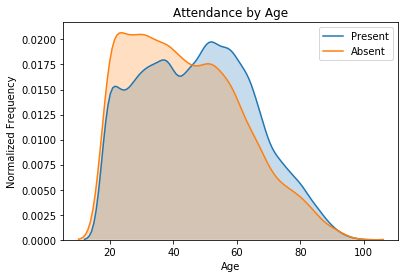

In [8]:
# Attendance distribution by Age
sns.kdeplot(df.loc[df['Attendance'] == 1, 'Age'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'Age'], label = 'Absent', shade = True)
plt.xlabel('Age')
plt.ylabel('Normalized Frequency')
plt.title('Attendance by Age')

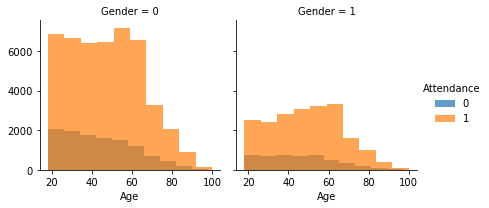

In [8]:
g = sns.FacetGrid(df, col="Gender", hue="Attendance")
g.map(plt.hist, "Age", alpha=.7)
g.add_legend();


- Many more women scheduling appointments than men
- Significant drop if scheduled appointments for patients older than 60 years old. Life expectancy in vitoria was 76.3 years in 2010 per http://www.atlasbrasil.org.br

In [9]:
def probStatus(dataset, group_by):
    df = pd.crosstab(index =dataset[group_by], columns = dataset.Attendance).reset_index()
    df['AttendanceProb'] = df.iloc[:,2]/(df.iloc[:,1]+df.iloc[:,2])
    return df[[group_by, 'AttendanceProb']]

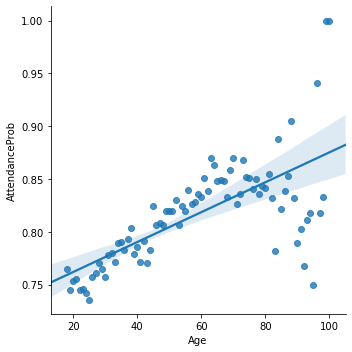

In [10]:

sns.lmplot(data=probStatus(df,'Age'), x='Age', y='AttendanceProb',fit_reg=True)


- Older patients are more likely to attend their appointments.
- More variance in relationship between attendance and age for patients over 80. 

### Date Analysis

Let's take a look at what dates we're examining here. We have both scheduled date and appointment date to dig into. Unfortunately the appointment date only provides the day/month/year of the visit while scheduled date gives the time of day. Some features we can extract from this data:

- WaitingDays : difference between scheduled date and appointment date
- AppointmentDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- ScheduledDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- AppointmentTimeOfDay: AM / PM



In [11]:
print(df.AppointmentDay.head(),
df.ScheduledDay.head())

0    2016-04-29T00:00:00Z
1    2016-04-29T00:00:00Z
2    2016-04-29T00:00:00Z
4    2016-04-29T00:00:00Z
5    2016-04-29T00:00:00Z
Name: AppointmentDay, dtype: object 0    2016-04-29T18:38:08Z
1    2016-04-29T16:08:27Z
2    2016-04-29T16:19:04Z
4    2016-04-29T16:07:23Z
5    2016-04-27T08:36:51Z
Name: ScheduledDay, dtype: object


In [12]:
#Pandas offers nifty support for analyzing datetimes. Let's convert these series into pandas 
#datatime objects with pd.to_datetime
df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)
print("Appointments occur between",df.AppointmentDay.min(),"and", df.AppointmentDay.max())

Appointments occur between 2016-04-29 00:00:00+00:00 and 2016-06-08 00:00:00+00:00


- This is **roughly five weeks** of appointments. This is likely another major limitation of building a model from this data.
- Notice that hour:min:sec data is not recorded for the appointment though this data is captured for the scheduling time

Text(0.5, 1.0, 'Mean Attendance by appointment day of week')

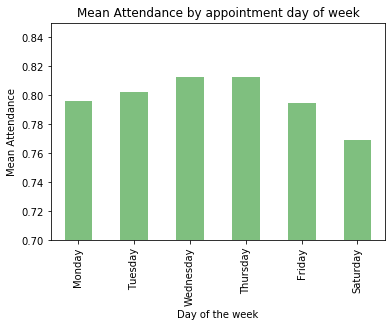

In [13]:
##Create a new column that tracks the appointment day of week (Mon, Tuesday, Wednesday, Thurs, Fri, Sat, Sun)
## Add this new column to our dataframe
df['AppointmentDayOfWeek'] = df.AppointmentDay.map(lambda day: day.day_name())

AttendancebyDay = df['Attendance'].groupby(df['AppointmentDayOfWeek'],sort=False)

AttendancebyDay.mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Mean Attendance')
plt.xlabel('Day of the week')
plt.ylim((0.7, 0.85))
plt.title('Mean Attendance by appointment day of week')

- Drop in attendance on Friday and Saturday
- Highest attendance on Wednesday and Thursday appointments 

In [14]:
#creates dummy variables to account for AppointmentdAyOfWeek Categorical data
dummy = pd.get_dummies(df.AppointmentDayOfWeek)
df= pd.concat([df,dummy], axis =1)

Text(0.5, 1.0, 'Rate of Attendance by Day Appointment Scheduled')

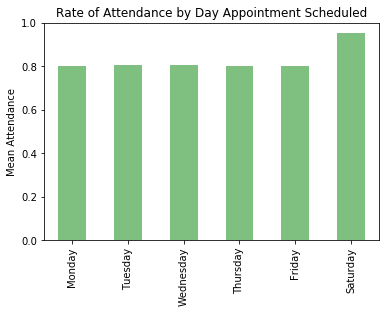

In [15]:
##Create a new column that tracks the scheduled day of week
df['ScheduledDayOfWeek'] = df.ScheduledDay.map(lambda day: day.day_name())

Attendancebyday = df['Attendance'].groupby(df['ScheduledDayOfWeek'])

Attendancebyday.mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).plot.bar(color='green',alpha=0.5)
plt.ylabel('Mean Attendance')
plt.xlabel('')
plt.title('Rate of Attendance by Day Appointment Scheduled')

- NEar 100% attendance for appointments scheduled on Saturday. Unfortunately there is a pretty low attendance rate on Saturday.
- LEt's check how many patients we're actually talking about


In [17]:
df.ScheduledDayOfWeek.apply(lambda x: str(x))
df.AppointmentDayOfWeek.apply(lambda x: str(x))
print("There are",df[(df.ScheduledDayOfWeek=='Saturday') | (df.AppointmentDayOfWeek =='Saturday')].shape[0],"instances of an appointment scheduled on Saturday")

There are 52 instances of an appointment scheduled on Saturday


Not a significant source of data. Seems these are not following the attendance pattern of Mon-Fri appointments. Drop and focus on appointments during the workweek 

In [18]:
df = df[df.ScheduledDayOfWeek!='Saturday']
df = df[df.AppointmentDayOfWeek!='Saturday']

In [19]:
def convertdaytonumber(day):
    if day == 'Monday':
        return 1
    if day == 'Tuesday':
        return 2
    if day == 'Wednesday':
        return 3
    if day == 'Thursday':
        return 4
    if day == 'Friday':
        return 5
    if day == 'Saturday':
        return 6
    if day == 'Sunday':
        return 7

##Create new features to represent which day the patient scheduled their appointment. 
df['ScheduledDayOfWeekNumeric'] = df.ScheduledDayOfWeek.map(lambda day: convertdaytonumber(day))
df = df.assign(ScheduledMonday = (df['ScheduledDayOfWeekNumeric'] == 1)*1, 
                         ScheduledTuesday = (df['ScheduledDayOfWeekNumeric'] == 2)*1, 
                         ScheduledWednesday = (df['ScheduledDayOfWeekNumeric'] == 3)*1,
                         ScheduledThursday = (df['ScheduledDayOfWeekNumeric'] == 4)*1,
                         ScheduledFriday = (df['ScheduledDayOfWeekNumeric'] == 5)*1)
df= df.drop('ScheduledDayOfWeekNumeric', axis=1)


Now we have dummy variables for each day of the week for when the appointment was scheduled and the actual day of the appointment

In [21]:
##This will calculate the days in between appointment and scheduling date. Since the appointment column doens't have a
## time of appointment, we're rounding here. Basically removing the time format from the ScheduledDate section.
WaitFromScheduledDate = (df.AppointmentDay.map(lambda x: x.date()) - df.ScheduledDay.map(lambda x: x.date()))

df['WaitFromScheduledDate'] = WaitFromScheduledDate.map(lambda x: x.days)

Text(0, 0.5, 'Instances')

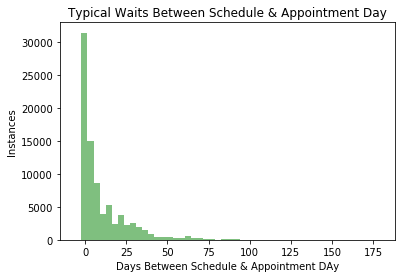

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df.WaitFromScheduledDate, bins = 50, color ='green', alpha = 0.5)
ax1.set_title('Typical Waits Between Schedule & Appointment Day')
ax1.set_xlabel('Days Between Schedule & Appointment DAy')
ax1.set_ylabel('Instances')



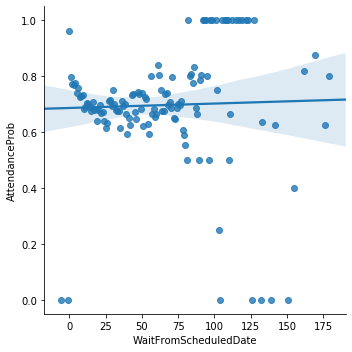

In [26]:
sns.lmplot(data = probStatus(df, 'WaitFromScheduledDate'), x= 'WaitFromScheduledDate', y= 'AttendanceProb', fit_reg=True)

Lots of no shows and variance in appointment attendance for patients who are waiting more than 125 days for their appointment. Makes some logical sense- a lot can change in four months time. Appointments scheduled this far out ought to receive more involved treatment in order to ensure that these patients remember and attend their appointments, if they're still in the area

In [ ]:
df = df[(df.WaitFromScheduledDate >= 0) & (df.WaitFromScheduledDate<=125)]
#Eliminate all records where wait time is less than 0 days
#Negative difference between scheduled date and appointment day makes no sense. Drop these values.

### SMS Reminder Analysis

SMS_Reminders
0    0.839256
1    0.732141
Name: Attendance, dtype: float64

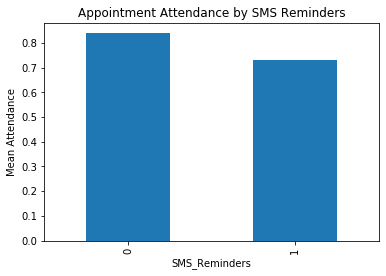

In [29]:
grouping = df['Attendance'].groupby(df['SMS_Reminders'])
grouping.mean().plot.bar()

plt.ylabel('Mean Attendance')
plt.title('Appointment Attendance by SMS Reminders')
grouping.mean()

Whoa. Those patients who did not receive an SMS reminders atteded their appointment 84% of the time compared to about 73% attendance among patients who received an SMS. This is a bit counter-intuitive. What's happening here? 


Perhaps the facility identifies patients at high risk of missing their appointment and sends SMS to those individuals? Perhaps its wealthier populations who can sign up for automated texting, who are also less likely to show up to a state-funded clinic appointment? Let's continue to dig into SMS relationships.

What percentage of patients are recieving texts by appointment day?

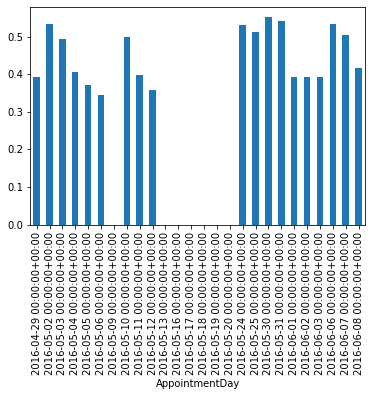

In [30]:
#How frequently are text messages sent from the facility?
grouping = df['SMS_Reminders'].groupby(df['AppointmentDay'])
grouping.mean().plot.bar()

Looks like for each appointment day in the data, somewhere between 35-55% of patients received an SMS reminder. 

The blank space between 5/15 and 5/23 pops out in this image. There's over a week of time where appointments were taken, but no SMS reminders were sent! Was the system down? How many records is this?

This could muddy the relationship between text reminders and attendance.

In [31]:
#Confirming the dates when no texts were distributed
df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].SMS_Reminders.mean()

print("There are", df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0], "records during this window",
     "or", "{:.1%}".format(df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0]/df.shape[0]), "percent of the data")

There are 15987 records during this window or 19.3% percent of the data


It's costly to discard 19% of your data for model building/testing- but we should do so. For whatever reason texts were not distributed for a whole week on an already limited dataset. So it's going to be very tricky to make any determinations about how texting affects the attendance rate without accounting for this week.

Ran the models with and without these data. When removing this week worth of data, the accuracy improved by 2%. Models seems to have a much harder time to predict guage the attendance relationship when trying to account for this week. Let's remove this week of data.

In [32]:
df = df[(df.AppointmentDay<"2016-05-15") | (df.AppointmentDay > "2016-05-23")]

SMS_Reminders
0    0.859602
1    0.732141
Name: Attendance, dtype: float64

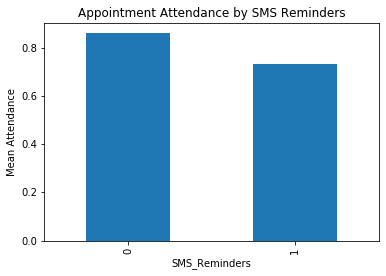

In [33]:
#Check the attendance to SMS relationship now.
grouping = df['Attendance'].groupby(df['SMS_Reminders'])
grouping.mean().plot.bar()

plt.ylabel('Mean Attendance')
plt.title('Appointment Attendance by SMS Reminders')
grouping.mean()

It's now even more glaring! People who did not receive an SMS were more likely to show up to their appointment. Waht else could be going on?

WaitFromScheduledDate
0    0.962823
1    0.801655
2    0.766102
3    0.766295
4    0.781961
5    0.745117
6    0.765540
7    0.720830
8    0.731139
9    0.734756
Name: Attendance, dtype: float64


Text(0.5, 1.0, 'Appointment Attendance by Days Awaiting Appointment')

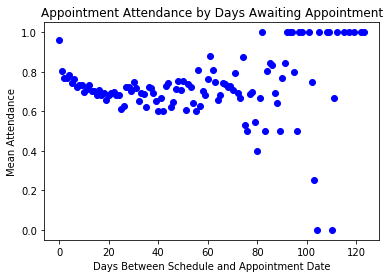

In [35]:
grouping = df['Attendance'].groupby(df['WaitFromScheduledDate'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'bo')
plt.ylabel('Mean Attendance')
plt.xlabel('Days Between Schedule and Appointment Date')
plt.title('Appointment Attendance by Days Awaiting Appointment')

People who made appointments THAT day were very likely to show up (~95%). Maybe these were patients who didn't receive an SMS? Let's check that grouping.

Additionally, there's a lot of variance in the relationship between attendance and Wait from scheduled date when observing patients who scheduled appointments beyond 125 days out. Let's cut these. Recommend that the facility follow up less than one or two months out to confirm the appointment. 

In [36]:
print("There are",df[df.WaitFromScheduledDate >125].shape[0], "instances in the data of patients who scheduled their appointment over 125 days out.")
df = df[df.WaitFromScheduledDate <=125]
#Eliminate the records of patients waiting more than 125 days

There are 0 instances in the data of patients who scheduled their appointment over 125 days out.


WaitFromScheduledDate
0    0.000000
1    0.000000
2    0.000000
3    0.415737
4    0.720989
5    0.816895
6    0.816067
7    0.755906
8    0.759259
9    0.791667
Name: SMS_Reminders, dtype: float64


Text(0.5, 1.0, 'SMS Reminder Rate by Days Awaiting Appointment')

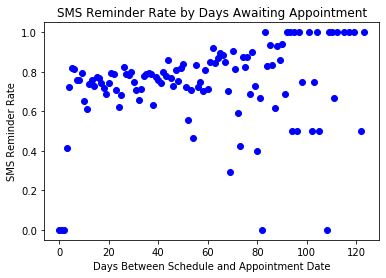

In [37]:
grouping = df['SMS_Reminders'].groupby(df['WaitFromScheduledDate'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'bo')
plt.ylabel('SMS Reminder Rate')
plt.xlabel('Days Between Schedule and Appointment Date')
plt.title('SMS Reminder Rate by Days Awaiting Appointment')

In [38]:
print("Roughly", "{:.1%}".format(df[df.WaitFromScheduledDate == 0].shape[0]/df.shape[0]), "percent of the records are of patients who scheduled their appointment on that very day") 

Roughly 33.2% percent of the records are of patients who scheduled their appointment on that very day


Interesting. So patients who scheduled their appointment for that day, or in the next couple days, will not receive text reminders for their appointment- further complicating the relationship between attendance and SMS reminders. 

It makes some sense that patients who scheduled appointments that day would not recieve a text reminder as 95% of patients in that bucket attended their appointment. Attendance does start to drop to 78-80% once looking past day-of appointments. So we might suggest that patients, even those scheduling appointments for the next day or day after, receive text reminders. 

In [78]:
import time
from datetime import datetime


In [79]:
def DaysBeforeCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'

In [185]:
##This bucketing will help specify to the model the category of patients who scheduled their appointment that day.
##These patients are very likely to attend their appointment. 
df['DaysBeforeCat'] = df.WaitFromScheduledDate.apply(DaysBeforeCat)

In [81]:
# DaysBeforeCat to dummies
def ant_days(df):
    df.loc[:, '0DaysWait'] = (df['DaysBeforeCat'] == '0 days')*1
    df.loc[:, '12DaysWait'] = (df['DaysBeforeCat'] == '1-2 days')*1
    df.loc[:, '37DaysWait'] = (df['DaysBeforeCat'] == '3-7 days')*1
    df.loc[:, '831DaysWait'] = (df['DaysBeforeCat'] == '8-31 days')*1
    df.loc[:, '32DaysWait'] = (df['DaysBeforeCat'] == '> 31 days')*1
    
ant_days(df)



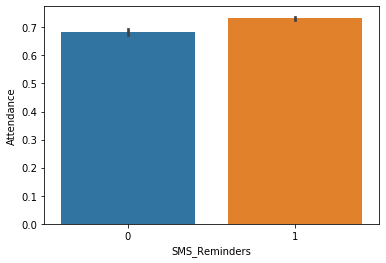

In [39]:
sns.barplot(x='SMS_Reminders',y='Attendance', data=df[df.WaitFromScheduledDate >2], orient = 'v')
#USing Wait time >2 because there are no text messages sent when the appointment is within 
#three days of the schedule date


In [40]:
##Can turn the datetime object into a new feature representing the hour of the day (24:00 clock)
def calculateHour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])
    return round(hour + minute/60 + second/3600)

df['ScheduledHourOfDay'] = df.ScheduledDay.apply(calculateHour)

This will return the hour of the day closest to when the apointment was scheduled. Perhaps there's a time of day when setting follow-up reminders in place are missed. 

We're not applying this to AppointmentDay because that level of specificity wasn't tracked across the appointments in the original data (only year - month - day)

Text(0.5, 1.0, 'Appointment Attendance by Scheduled Time of Day')

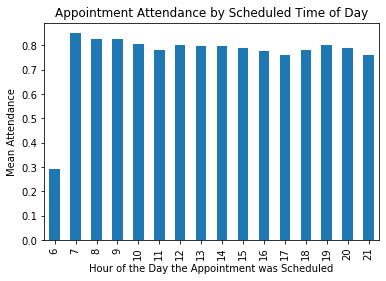

In [41]:
grouping = df['Attendance'].groupby(df['ScheduledHourOfDay'])
grouping.mean().plot.bar()
plt.ylabel('Mean Attendance')
plt.xlabel('Hour of the Day the Appointment was Scheduled')
plt.title('Appointment Attendance by Scheduled Time of Day')

Appointments scheduled during the 6am hour seems to be outliers. Very low attendance. Only coming from neighborhood regions A, B, and C. Pass on these 25 records. 

In [42]:
df = df[df.ScheduledHourOfDay != 6]

Text(0.5, 1.0, 'Time of Day Scheduling the Appointment on Days Before Appointment')

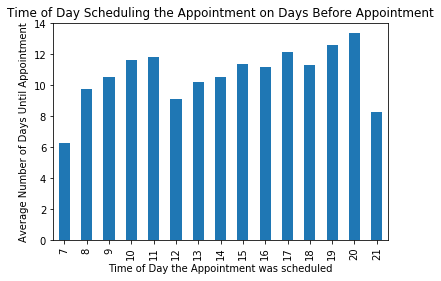

In [43]:
grouping = df['WaitFromScheduledDate'].groupby(df['ScheduledHourOfDay'])
grouping.mean().plot.bar()
#plt.plot(grouping.mean())
plt.ylabel('Average Number of Days Until Appointment')
plt.xlabel('Time of Day the Appointment was scheduled')
plt.title('Time of Day Scheduling the Appointment on Days Before Appointment')


- Patients are less likely to attend appointments when scheduled later in the day
- Appointments scheduled early in the morning (7am) or late at night (9pm) are scheduled closer to the scheduled date. May be emergency situations. 
- Appointments scheduled between 5-9pm seem to be scheduled for a later date on average. 

### Group appointments by patient ID

In [44]:
print("There are",len(df.PatientId.unique()),"unique patients in the data")
print("There are",len(df.AppointmentID.unique()),"unique appointment Ids in the data")
print("{:.1%}".format(df.PatientId.unique().shape[0]/df.shape[0]), "of the data are unique patients")
print("{:.1%}".format(1-(df.PatientId.unique().shape[0]/df.shape[0]))," of the data are returning patients")



There are 39963 unique patients in the data
There are 67001 unique appointment Ids in the data
59.6% of the data are unique patients
40.4%  of the data are returning patients


Since we note a significant chunk of the data are returning patients, let's create a new variable that tracks how may appointments the patient has scheduled. The appointment frequency could be an important variable to building this model. Also of interest, prior attendance rate of the patient and attendance at last appointment. 

In [45]:
ScheduledAppointmentFrequencies = pd.value_counts(df.PatientId.values, sort=True)
print("The mean number of scheduled appointments is ", ScheduledAppointmentFrequencies.mean())
ScheduledAppointmentFrequencies.describe()
ScheduledAppointmentFrequencies.head()

The mean number of scheduled appointments is  1.6765758326451967


8.221459e+14    69
9.963767e+10    68
2.688613e+13    57
3.353478e+13    54
8.713749e+14    53
dtype: int64

Text(0, 0.5, 'Count of patients')

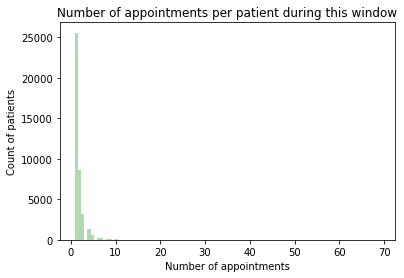

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(ScheduledAppointmentFrequencies, bins = 100, color ='green', alpha = 0.7)
ax1.set_title('Number of appointments per patient during this window')
ax1.set_xlabel('Number of appointments')
ax1.set_ylabel('Count of patients')

Most patients in our data have scheduled less than 10 appointments during this month+ window. Mean number of appointments in 1.7. We should be able to use this past attendance information to better predict future attendance. 

In [59]:
## Create two new variables Prior Appointments and Prior Absences
## these will look back in time and sum up all prior appointments or prior absences
#Set them both at 0 for aall patients
# then we will write scripts that go through each patient record and make appropriate updates
df['PriorAppts'] = 0
df['PriorAttendanceRate'] = 0

In [60]:
#create column that counts all the past appts
df['PriorAppts'] = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()

In [61]:
## create a column that calculates the attendance rate of each patient. 
grouping = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).Attendance.cumsum()
for index in df.index:
    df.loc[index, 'PriorAttendanceRate'] = (grouping[index] - df.loc[index,'Attendance'])/ df.loc[index,'PriorAppts']
    


/home/jordan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [62]:
PatientGrouping = df.groupby('PatientId')
for index in df.index:
    ApptPull = PatientGrouping.get_group(df.loc[index, 'PatientId'])[df.AppointmentDay < df.loc[index,'AppointmentDay']].AppointmentDay
    if not ApptPull.empty:
        try:
            df.at[index, 'LastApptDate'] = ApptPull.unique().max()
            df.at[index,'LastApptAttendance']=df.loc[ApptPull.idxmax(),'Attendance']
            
        except:
            pass


/home/jordan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


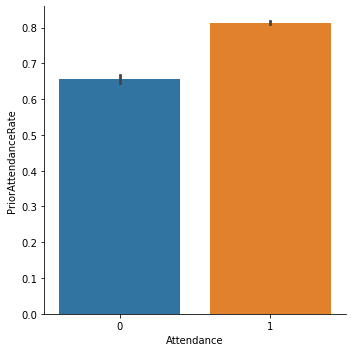

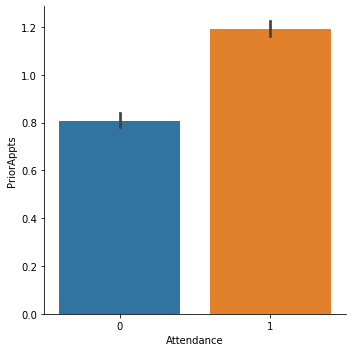

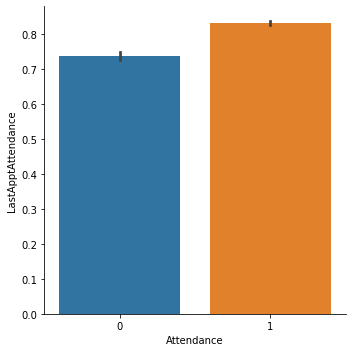

In [63]:
fig1=sns.catplot(x="Attendance", y="PriorAttendanceRate", kind='bar',  data=df)
fig2= sns.catplot(x="Attendance", y="PriorAppts", kind='bar',  data=df)
fig2= sns.catplot(x="Attendance", y="LastApptAttendance", kind='bar',  data=df)

#“point”, “bar”, “strip”, “swarm”, “box”, “violin”, or “boxen”.

### Neighborhood Analysis

Let's extract all the unique neighborhoods. Classify each neighborhood by its geographic location. Some places may be more accessible to medical care than others.

Went on Google maps and labeled each of the 81 neighborhoods into six regions by their geography and proximity to local clinics. You can see the map of all neighborhoods (blue) and clinics (red) here: <Link>

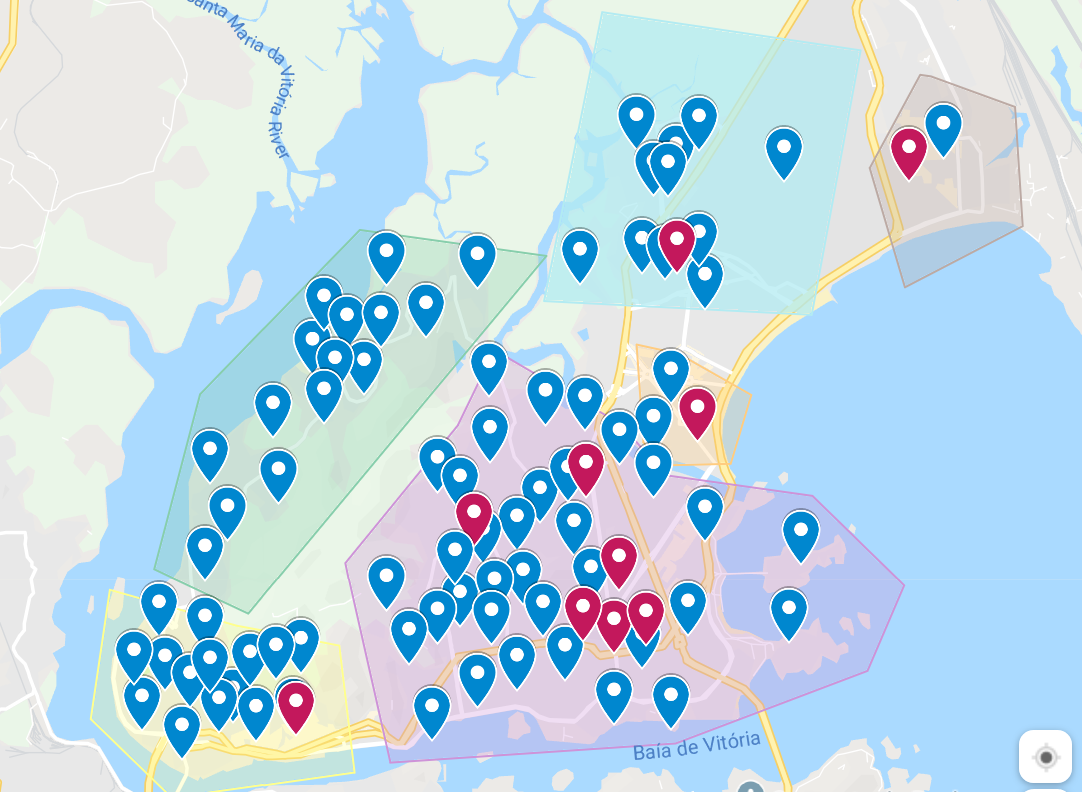

In [64]:
from IPython.display import Image
Image(filename='NeighborhoodGraphic.png') 
#Green = Region A
#Yellow = Region B
#Red = Region C
#Orange = Region D
#Blue = Region E
#Gray = Region F


In [65]:
#This is a local csv copy of all the neighborhoods and their regional attribute as shown in the map above
AllNeighborhoods = pd.read_csv("AllNeighborhoods.csv", usecols=["Neighborhood", "Grouping"],index_col= 'Neighborhood')

Text(0.5, 1.0, 'Attendance by Neighborhood')

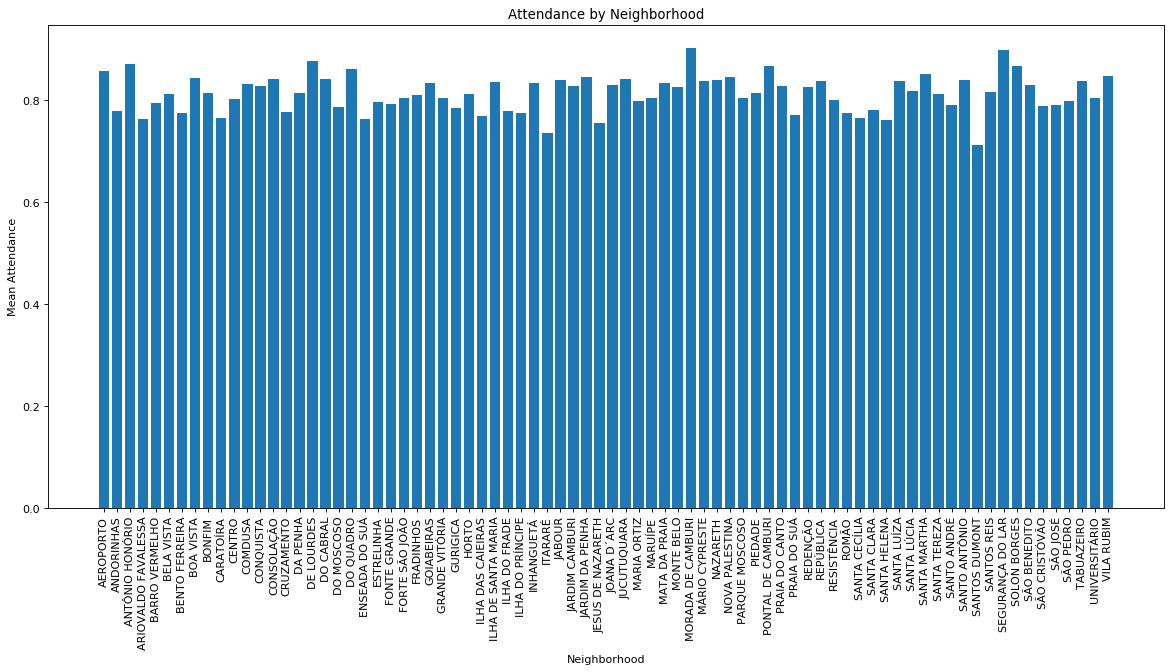

In [187]:
from matplotlib.pyplot import figure
grouping = df['Attendance'].groupby(df['Neighborhood'])
figure(num=None, figsize=(18, 8), dpi=80, facecolor='w', edgecolor='k')
plt.bar(grouping.mean().index,grouping.mean())
plt.ylabel('Mean Attendance')
plt.xlabel('Neighborhood')
plt.xticks(rotation=90)
plt.title('Attendance by Neighborhood')


Could not place ILHAS OCEÂNICAS DE TRINDADE or PARQUE INDUSTRIAL on the map. Check how many datapoints come from these neighborhoods. Might drop them.

In [67]:
df[((df.Neighborhood == "ILHAS OCEÂNICAS DE TRINDADE") | (df.Neighborhood == "PARQUE INDUSTRIAL") | (df.Neighborhood == "ILHA DO BOI"))].shape

(29, 33)

37 records of potential outliers when we look at neighborhoods, so let's drop these. 

In [68]:
df = df[-((df.Neighborhood == "ILHAS OCEÂNICAS DE TRINDADE") | (df.Neighborhood == "PARQUE INDUSTRIAL") | (df.Neighborhood == "ILHA DO BOI"))]

Okay so now I want to assign the new variable "Grouping" to the working dataframe, df. 

In [69]:
#First convert the neighborhoods to dictionary
AllNeighborhoods= AllNeighborhoods.to_dict()
AllNeighborhoods= AllNeighborhoods['Grouping']
df['NeighborhoodGrouping'] = df.Neighborhood
df.NeighborhoodGrouping = df.NeighborhoodGrouping.map(AllNeighborhoods)

/home/jordan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jordan/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Now let's create the six dummy variables so that we can use these data in our models. 

In [70]:

dummy = pd.get_dummies(df.NeighborhoodGrouping)
df= pd.concat([df,dummy], axis =1)

Text(0.5, 1.0, 'Count of Records by Neighborhood Region')

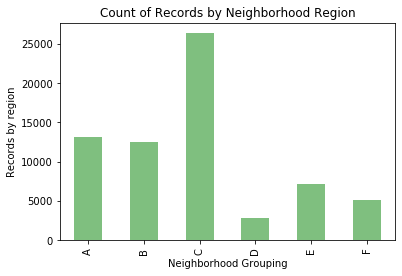

In [188]:
NeighboorhoodAttendance = df['Attendance'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodAttendance.count().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Records by region')
plt.xlabel('Neighborhood Grouping')
plt.ylim()
plt.title('Count of Records by Neighborhood Region')

Text(0.5, 1.0, 'Mean Attendance by Neighborhood Region')

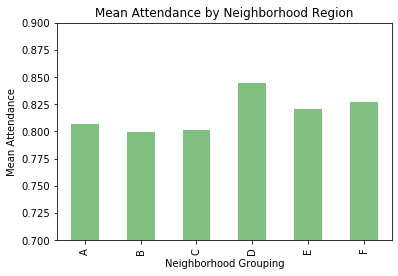

In [189]:
NeighboorhoodAttendance = df['Attendance'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodAttendance.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Mean Attendance')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0.7, 0.9))
plt.title('Mean Attendance by Neighborhood Region')

Text(0.5, 1.0, 'Alcoholism by Neighborhood Region')

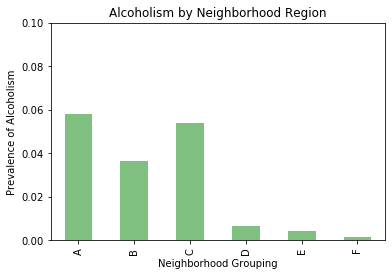

In [190]:
NeighboorhoodG = df['Alcoholism'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodG.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Prevalence of Alcoholism')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0,0.1))
plt.title('Alcoholism by Neighborhood Region')

Text(0.5, 1.0, 'Diabetes by Neighborhood Region')

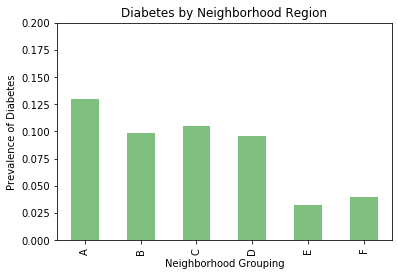

In [191]:
NeighboorhoodG = df['Diabetes'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodG.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Prevalence of Diabetes')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0,0.2))
plt.title('Diabetes by Neighborhood Region')

Text(0.5, 1.0, 'Scholarship by Neighborhood Region')

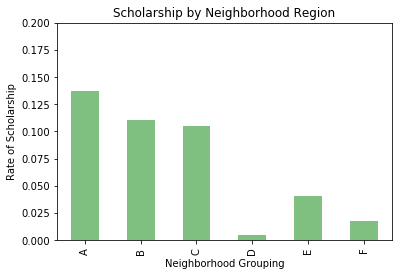

In [192]:
NeighboorhoodG = df['Scholarship'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodG.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Rate of Scholarship')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0,0.2))
plt.title('Scholarship by Neighborhood Region')

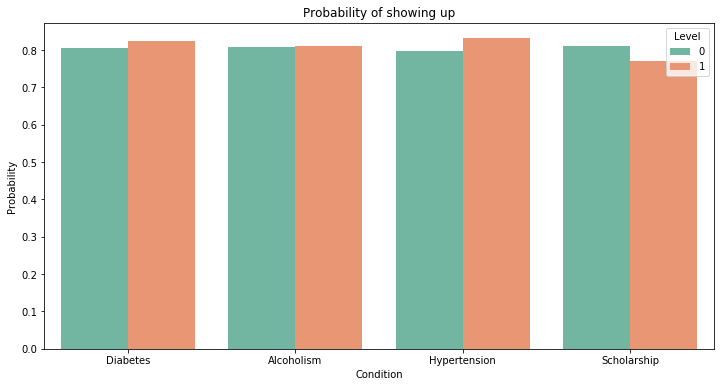

In [193]:

def probStatusCategorical(group_by):
    rows = []
    for item in group_by:
        for level in df[item].unique():
            row = {'Condition': item}
            total = len(df[df[item] == level])
            n = len(df[(df[item] == level) & (df.Attendance == 1)])
            row.update({'Level': level, 'Probability': n / total})
            rows.append(row)
    return pd.DataFrame(rows)
plt.figure(figsize=(12,6))

sns.barplot(data = probStatusCategorical(['Diabetes', 'Alcoholism', 'Hypertension', 'Scholarship']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

/home/jordan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


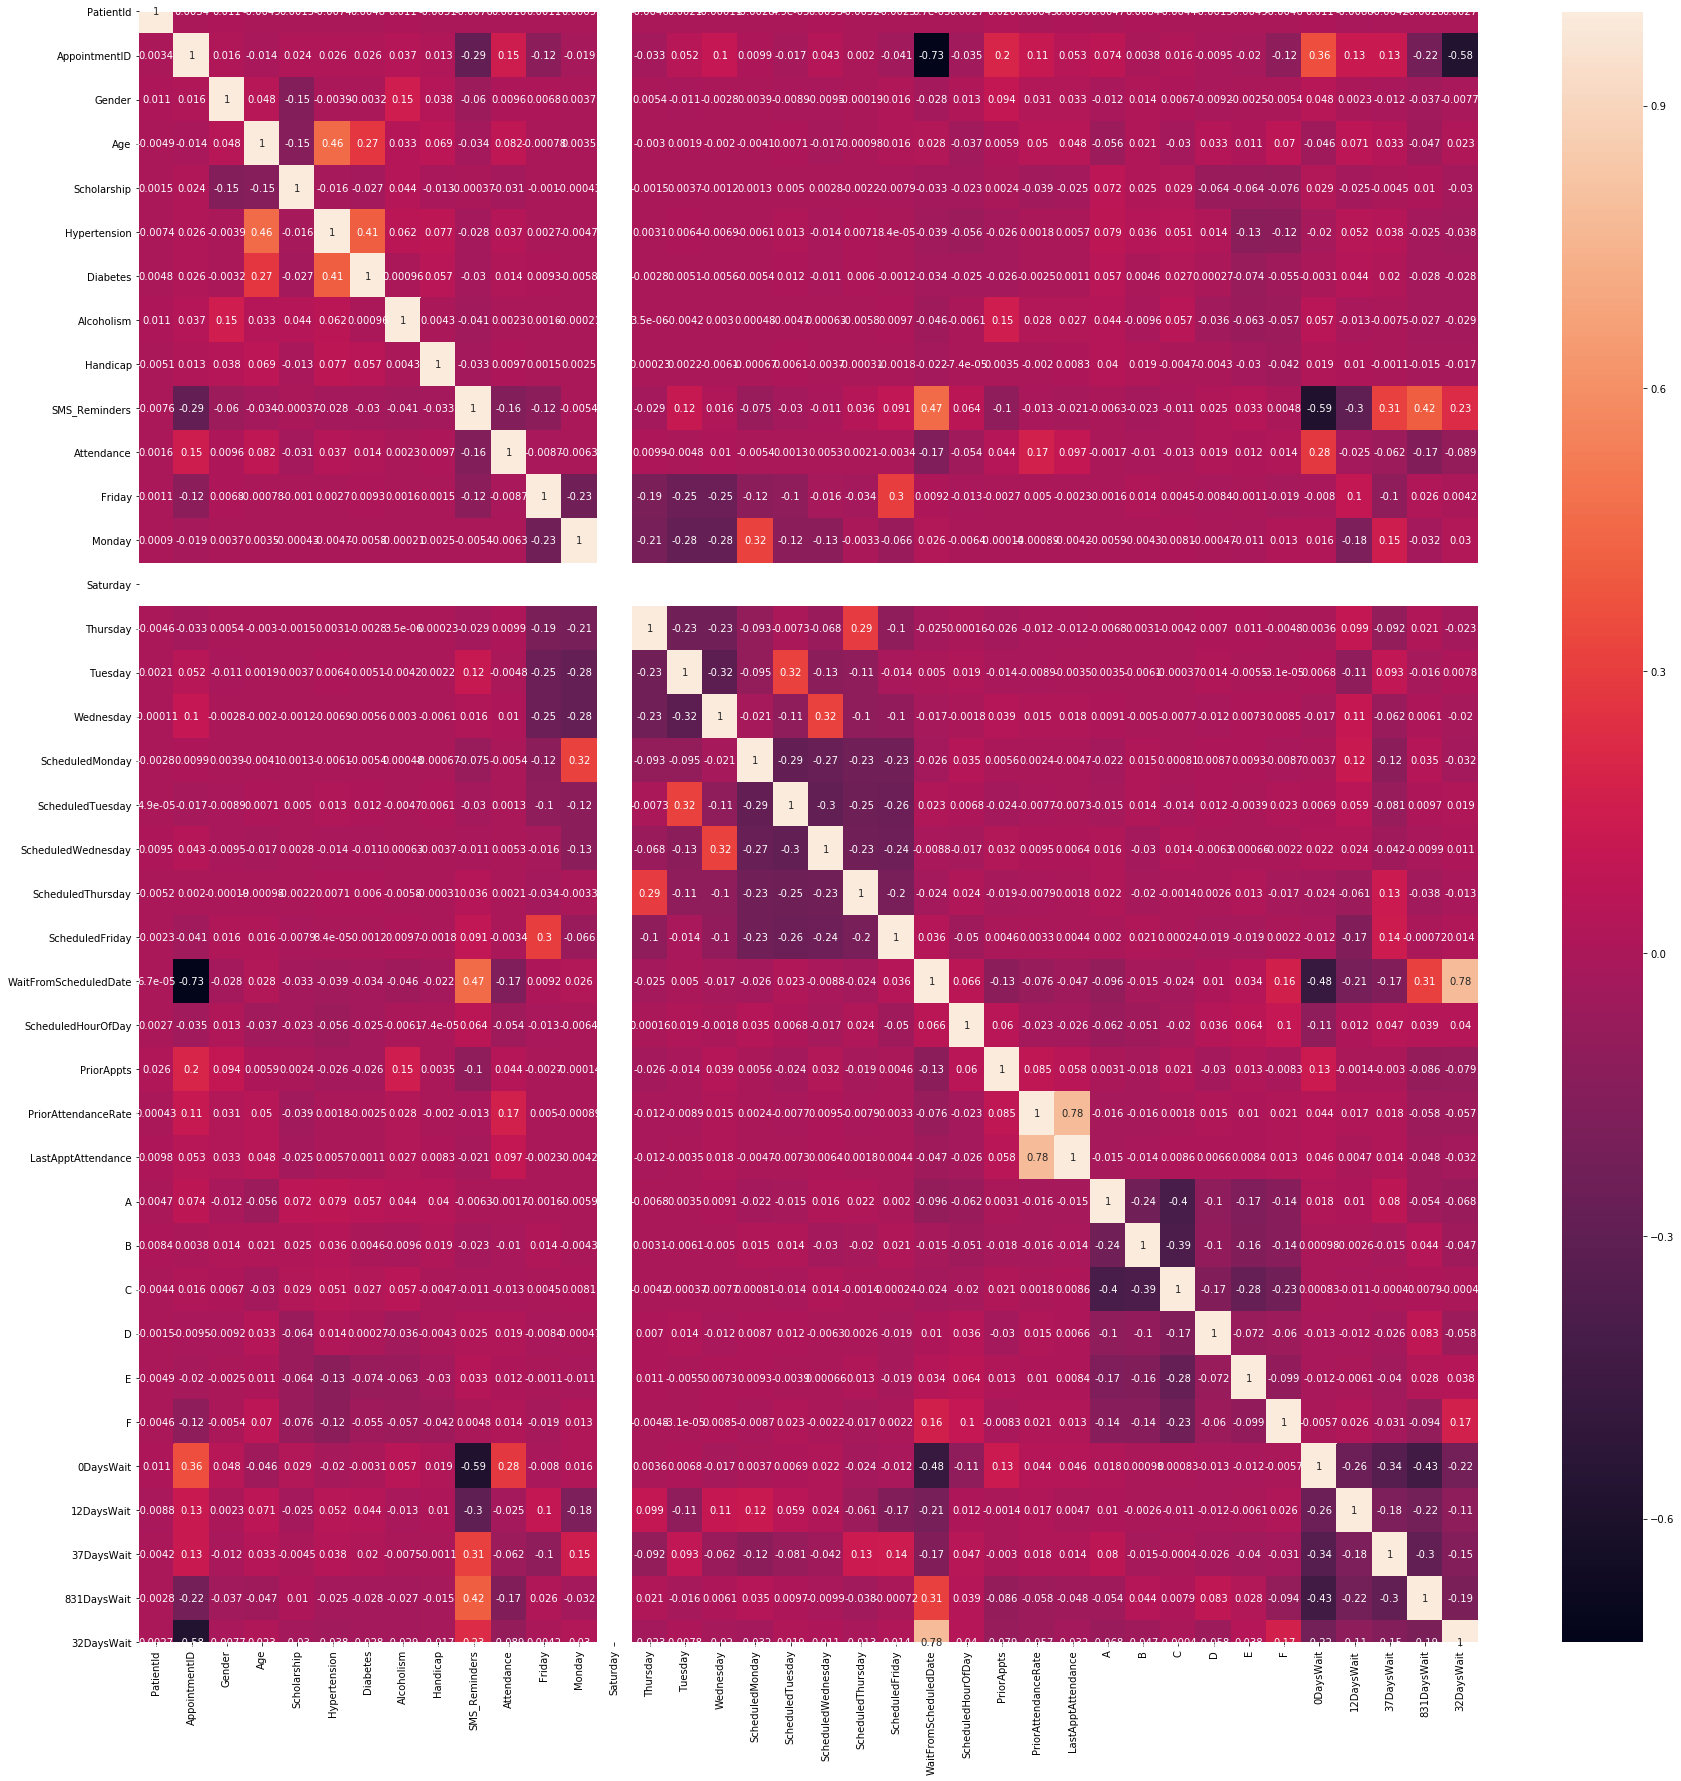

In [198]:
fig = plt.figure(figsize = (30,30))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
fig.show()
savefig('correlationmatrix.png')

### Model Building

In this notebook, we will walkthrough four different models with this data.

1. Naive Model (assume all patients attend)
2. Bayesian Optimized Gradient Boosting Model
3. Logistic Regression
4. Random Forest
5. Neural Network

First let's prep our data. What features are we keeping for model building? Then slice our data into training and testing. 

In [201]:


features = ['Gender', 'Age', 'Scholarship', 'Hypertension', 'AppointmentID',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 
       'Thursday', 'Tuesday',
       'Wednesday', 'WaitFromScheduledDate',
       'ScheduledHourOfDay', 'PriorAppts', 'PriorAttendanceRate', 'LastApptAttendance',
        'A', 'B', 'C', 'D', 'E', 'F',
       'ScheduledMonday', 'ScheduledTuesday', 'ScheduledWednesday',
       'ScheduledThursday', 'ScheduledFriday', '0DaysWait', '12DaysWait',
       '37DaysWait', '831DaysWait', '32DaysWait']

label = 'Attendance'

#Did not expect the data types in fields AppointmentDayOfWeek, ScheduledDayOfWeek, NeighborhoodGrouping, DaysBeforeCat

In [202]:
# Special thanks to https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [203]:
df = reduce_mem_usage(df)

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size=0.2, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

Mem. usage decreased to 10.04 Mb (0.0% reduction)


In [204]:
train.rename(columns={'Attendance_y':'Attendance'}, inplace=True)
test.rename(columns={'Attendance_y':'Attendance'}, inplace=True)

#### Naive Model (assume all patients attend)

In [208]:
NaivePreds = y_test.copy()
NaivePreds.Attendance =1
## This will be our naive model predicting every patient shows up

In [216]:
print(confusion_matrix(y_test, NaivePreds))
print(classification_report(y_test, NaivePreds))

[[    0  2649]
 [    0 10746]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2649
           1       0.80      1.00      0.89     10746

    accuracy                           0.80     13395
   macro avg       0.40      0.50      0.45     13395
weighted avg       0.64      0.80      0.71     13395



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Okay so any model we implement should improve upon 80% accuracy. In this naive model, we incorrectly predict that 2649 patients show up to their appointment. How well can we improve the F1- score of the no-show classification without negative impact to the accuracy?

#### Bayesian-Optimized Gradient Boosting Model

In [87]:
from bayes_opt import BayesianOptimization


In [88]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import shap 



def param_opt_xgb(X, y, init_round=10, opt_round=10, n_folds=3, random_seed=6, output_process=False):
    # Prepare data
    dtest = xgb.DMatrix(X, y)

    def xgb_eval(learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, scale_pos_weight):
        params = {'objective' : 'binary:logistic', 'nthread' : 4, 'seed' : random_seed, "silent":1}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['n_estimators'] = int(round(n_estimators))
        params['max_depth'] = int(round(max_depth))
        params['min_child_weight'] = int(round(min_child_weight))
        params['gamma'] = gamma
        params['subsample'] = max(min(subsample, 1), 0)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['scale_pos_weight'] = int(round(scale_pos_weight))

        cv_result = xgb.cv(params, dtest, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        
        
        return max(cv_result['train-auc-mean'])
    
    xgbBO = BayesianOptimization(xgb_eval, {'learning_rate': (0.01, 0.3),
                                                'n_estimators': (100, 200),
                                                'max_depth': (2, 7),
                                                'min_child_weight': (0, 7),
                                                'gamma': (0, 0.3),
                                                'subsample':(0.5,1),
                                                'colsample_bytree': (0.5, 1),
                                                'scale_pos_weight':(2,7)}, random_state=random_seed)

    xgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_aucpr=[]
    for model in range(len(xgbBO.res)):
        model_aucpr.append(xgbBO.res[model]['target'])

    # return best parameters
    return xgbBO.res[pd.Series(model_aucpr).idxmax()]['target'],xgbBO.res[pd.Series(model_aucpr).idxmax()]['params']


/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [89]:
opt_params = param_opt_xgb(df[features], df[label])

/home/jordan/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jordan/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	train-auc:0.688921+0.0084207	test-auc:0.690456+0.00820654
[9]	train-auc:0.725297+0.00374414	test-auc:0.723967+0.00288223
|  1        |  0.7253   |  0.9464   |  0.09959  |  0.2482   |  2.208    |  0.7536   |  159.5    |  4.649    |  0.7094   |
[0]	train-auc:0.725071+0.000959853	test-auc:0.719676+0.00217577
[9]	train-auc:0.751169+0.00149541	test-auc:0.735916+0.0021548
|  2        |  0.7512   |  0.6677   |  0.1868   |  0.1371   |  5.679    |  3.626    |  157.9    |  5.227    |  0.9951   |
[0]	train-auc:0.72323+0.00158501	test-auc:0.719328+0.00187922
[9]	train-auc:0.755897+0.000591894	test-auc:0.738416+0.00106991
|  3        |  0.7559   |  0.9099   |  0.124    |  0.2641   |  6.119    |  0.3813   |  171.9    |  6.011    |  0.8682   |
[0]	train-auc

In [90]:
opt_params[1]['n_estimators'] = int(round(opt_params[1]['n_estimators']))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_child_weight'] = int(round(opt_params[1]['min_child_weight']))
opt_params[1]['scale_pos_weight'] = int(round(opt_params[1]['scale_pos_weight']))
opt_params[1]['objective']='binary:logistic'
opt_params[1]['metric']='auc'
opt_params[1]['nthread']=4
opt_params[1]['seed']=6
opt_params=opt_params[1]
opt_params

{'colsample_bytree': 0.7657159247624385,
 'gamma': 0.08279543848021748,
 'learning_rate': 0.20605284834756663,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 125,
 'scale_pos_weight': 2,
 'subsample': 0.8615148819570123,
 'objective': 'binary:logistic',
 'metric': 'auc',
 'nthread': 4,
 'seed': 6}

In [91]:
def modelfit(alg, dtrain, dtest, predictors, target, eval_metric = True):
        #Fit the algorithm on the data
        if eval_metric:
            alg.fit(dtrain[predictors], dtrain[target].values.ravel(), eval_metric = ['auc'])
        else: 
            alg.fit(dtrain[predictors], dtrain[target].values.ravel())
            
        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
        #Predict test set:
        dtest_predictions = alg.predict(dtest[predictors])
        dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
            
        #Print model report:
        print( " Model Report")
        print("Accuracy Train: %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("Recall Train: %.4g" % metrics.recall_score(dtrain[target].values, dtrain_predictions))
        print("Accuracy Test: %.4g" % metrics.accuracy_score(dtest[target].values, dtest_predictions))
        print("Recall Test: %.4g" % metrics.recall_score(dtest[target].values, dtest_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

In [92]:
xgb1 = XGBClassifier(
        learning_rate =opt_params['learning_rate'],
        n_estimators=opt_params['n_estimators'],
        max_depth=6,
        min_child_weight=opt_params['min_child_weight'],
        gamma=opt_params['gamma'],
        subsample=opt_params['subsample'],
        colsample_bytree=opt_params['colsample_bytree'],
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=opt_params['scale_pos_weight'],
        seed=6)

modelfit(xgb1, train, test, features, target = label)

 Model Report
Accuracy Train: 0.8229
Recall Train: 0.9992
Accuracy Test: 0.8072
Recall Test: 0.996
AUC Score (Train): 0.848439


In [95]:
print(confusion_matrix(y_train, xgb1.predict(train[features])))
print(classification_report(y_train, xgb1.predict(train[features])))

[[  778  9457]
 [   34 43308]]
              precision    recall  f1-score   support

           0       0.96      0.08      0.14     10235
           1       0.82      1.00      0.90     43342

    accuracy                           0.82     53577
   macro avg       0.89      0.54      0.52     53577
weighted avg       0.85      0.82      0.76     53577



In [94]:
print(confusion_matrix(y_test, xgb1.predict(test[features])))
print(classification_report(y_test, xgb1.predict(test[features])))

[[  110  2539]
 [   43 10703]]
              precision    recall  f1-score   support

           0       0.72      0.04      0.08      2649
           1       0.81      1.00      0.89     10746

    accuracy                           0.81     13395
   macro avg       0.76      0.52      0.49     13395
weighted avg       0.79      0.81      0.73     13395



Our model is accurately identifying patients attendance 81% of the time. Particularly interesting, the model when predicting a no-show is accruate on the training set 96% of the time and 72% of the time on the test set. 

Let's consider what features are most significant to this model.

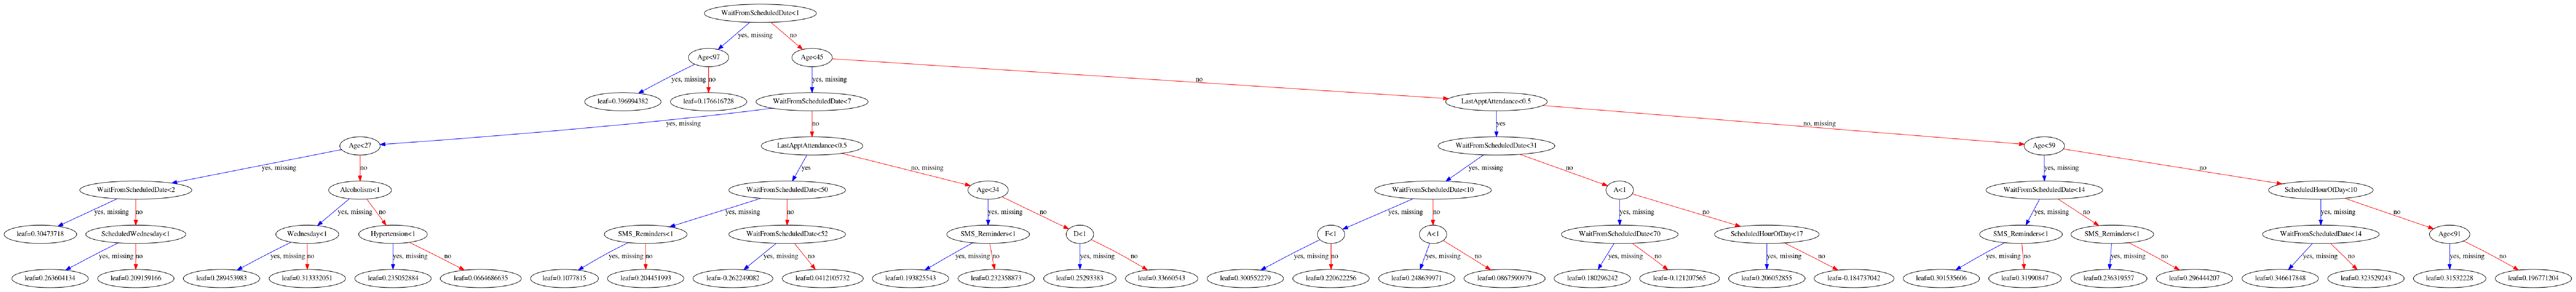

In [97]:
from xgboost import plot_tree
from matplotlib.pyplot import *
#plt.figure(num=None, figsize=(24, 24), dpi=80, facecolor='w', edgecolor='k')
#plot_tree(xgb1)
#plt.savefig('tree.png')




xgb.plot_tree(xgb1)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

Commentary on the tree

In [120]:
#Let's look at at our test dataset and identify where there may be bias in our model
xgb1.predict_proba(test[features])
test['probabilityByxgb'] = xgb1.predict_proba(test[features])[:,1]

In [184]:
from tabulate import tabulate
print(tabulate([["Scholarship","{:.1%}".format(test[(test.Attendance == 0)].Scholarship.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Scholarship.mean())],
                
                
                ["Age", "{:.3}".format(test[(test.Attendance == 0)].Age.mean()),
                 "{:.3}".format(test[(test.probabilityByxgb <0.5)].Age.mean())],  
                
                ["Hypertension","{:.1%}".format(test[(test.Attendance == 0)].Hypertension.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Hypertension.mean())],
               
               ["Diabetes","{:.1%}".format(test[(test.Attendance == 0)].Diabetes.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Diabetes.mean())],
                
                ["Alcoholism","{:.1%}".format(test[(test.Attendance == 0)].Alcoholism.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Alcoholism.mean())],
               
               ["NeighborhoodA","{:.1%}".format(test[(test.Attendance == 0)].A.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].A.mean())],               

               ["NeighborhoodB","{:.1%}".format(test[(test.Attendance == 0)].B.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].B.mean())],  
               ["NeighborhoodC","{:.1%}".format(test[(test.Attendance == 0)].C.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].C.mean())],                  
               ["NeighborhoodD","{:.1%}".format(test[(test.Attendance == 0)].D.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].D.mean())],                  
               ["NeighborhoodE","{:.1%}".format(test[(test.Attendance == 0)].E.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].E.mean())],  
                
               ["NeighborhoodF","{:.1%}".format(test[(test.Attendance == 0)].F.mean()), 
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].F.mean())],                  
                
                ["Prior Appointments","{:.3}".format(test[(test.Attendance == 0)].PriorAppts.mean()),
                 "{:.3}".format(test[(test.probabilityByxgb <0.5)].PriorAppts.mean())],
                
                ["Prior Attendance", "{:.1%}".format(test[(test.Attendance == 0)].PriorAttendanceRate.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].PriorAttendanceRate.mean())],
                
                ["Percent of males", "{:.1%}".format(test[(test.Attendance == 0)].Gender.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Gender.mean())],                

                ["SMS Reminders", "{:.1%}".format(test[(test.Attendance == 0)].SMS_Reminders.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].SMS_Reminders.mean())],                    

                ["Appt - Schedule Date", "{:.3}".format(test[(test.Attendance == 0)].WaitFromScheduledDate.mean()),
                 "{:.3}".format(test[(test.probabilityByxgb <0.5)].WaitFromScheduledDate.mean())],                 
                
                 ["Last Appointment Attendance", "{:.1%}".format(test[(test.Attendance == 0)].LastApptAttendance.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].LastApptAttendance.mean())],   
                
                 ["Scheduled Hour of the day", "{:.3}".format(test[(test.Attendance == 0)].ScheduledHourOfDay.mean()),
                 "{:.3}".format(test[(test.probabilityByxgb <0.5)].ScheduledHourOfDay.mean())], 

                
                 ["Monday Appt", "{:.1%}".format(test[(test.Attendance == 0)].Monday.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Monday.mean())],                   
                
                 ["Tuesday Appt", "{:.1%}".format(test[(test.Attendance == 0)].Tuesday.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Tuesday.mean())],   
                
                 ["Wednesday Appt", "{:.1%}".format(test[(test.Attendance == 0)].Wednesday.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Wednesday.mean())],                   
                
                
                 ["Thursday Appt", "{:.1%}".format(test[(test.Attendance == 0)].Thursday.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Thursday.mean())],                   
                
                 ["Friday Appt", "{:.1%}".format(test[(test.Attendance == 0)].Friday.mean()),
                 "{:.1%}".format(test[(test.probabilityByxgb <0.5)].Friday.mean())],                   
                
                
                
                
                
                
                
                
                
                
               ], headers=['Feature', 'Representation in test', 'Representation among predicted no-shows in test']))

Feature                      Representation in test    Representation among predicted no-shows in test
---------------------------  ------------------------  -------------------------------------------------
Scholarship                  11.0%                     18.3%
Age                          44.1                      41.3
Hypertension                 23.9%                     24.2%
Diabetes                     9.4%                      10.5%
Alcoholism                   3.9%                      6.5%
NeighborhoodA                19.2%                     22.2%
NeighborhoodB                18.8%                     19.0%
NeighborhoodC                41.4%                     35.9%
NeighborhoodD                3.8%                      2.6%
NeighborhoodE                10.2%                     9.8%
NeighborhoodF                6.6%                      10.5%
Prior Appointments           0.874                     1.66
Prior Attendance             67.4%                     9.5%
Perce

Where might the algorithm be skewed? The list above shows up the representation of the test set vs model predictions. On the left, are the feature representations among patients who actually missed their appointment in the test set. On the right are the feature representations among the predicted no-shows on the test set. Ideally these representations would be roughly similar. Any deviances can suggest to us where the algorithm might be biased. 


A few variables jump out on first glance. More digging would be required to determine if these differences are statistically siginificant or sources of error of the model:

- Model is tagging a lot of patients who are scholarship as no-shows. This is particularly interesting because Scholarship is not used as a node in the XGB decision tree.
- Model tags more alcoholics has no-shows than represented in the test set.
- Model tags more patients from Neighborhood F as no-shows. This is interesting because patients in neighborhood F typically schedule their appointments for further out. The model also bends towards predicting patients who schedule their appointments much further out as no-shows. 
- Our model is selecting a population that has scheduled multiple appointments in the past and rarely comes to their appointment. Though in the test set there's a much lower frequency of prior appointments and a much higher prior attendance rate compared to model predictions. Our model is missing a lot of no-shows here. 
- ~60% of the test set no-shows recieved SMS reminders. Our model only predicted a selection of no shows where 35% of patients recieved SMS reminders. 
- Scheduling a Monday or Tuesday appointment made it more likely the model would predict you as a no-show. Model had a hard time predicting who would miss their Thursday appointments. 

#### Logistic Regression

The following models will not play nicely with some of the NaNs in the dataset. Recall we have these from the PriorAttendanceRate column. If the appointment is the patient's first appointment, this field sets as NAN. We will replace these with 0. 

In [218]:
df = df.fillna(0)
df.dtypes
df.isnull().values.any()

False

Scaling down all our features to make more more efficient computing. Will be very valuable when we get to random forests and neural networks. 

In [219]:
scaler = StandardScaler().fit(df[features])
df_rescaled = scaler.transform(df[features])

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size=0.2, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

In [231]:
logit = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
modelfit(logit, train, test, features, label, eval_metric = False)
print(confusion_matrix(y_test, logit.predict(test[features])))
print(classification_report(y_test, logit.predict(test[features])))

 Model Report
Accuracy Train: 0.6702
Recall Train: 0.6947
Accuracy Test: 0.664
Recall Test: 0.6918
AUC Score (Train): 0.667132
[[1460 1189]
 [3312 7434]]
              precision    recall  f1-score   support

           0       0.31      0.55      0.39      2649
           1       0.86      0.69      0.77     10746

    accuracy                           0.66     13395
   macro avg       0.58      0.62      0.58     13395
weighted avg       0.75      0.66      0.69     13395



In [222]:
tree = DecisionTreeClassifier(max_depth=12, random_state=0)
modelfit(tree, train, test,features, label, eval_metric=False)

print(confusion_matrix(y_test, tree.predict(test[features])))
print(classification_report(y_test, tree.predict(test[features])))

 Model Report
Accuracy Train: 0.8381
Recall Train: 0.9839
Accuracy Test: 0.7912
Recall Test: 0.9591
AUC Score (Train): 0.818479
[[  291  2358]
 [  439 10307]]
              precision    recall  f1-score   support

           0       0.40      0.11      0.17      2649
           1       0.81      0.96      0.88     10746

    accuracy                           0.79     13395
   macro avg       0.61      0.53      0.53     13395
weighted avg       0.73      0.79      0.74     13395



In [223]:
rf = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
modelfit(rf, train, test,features, label, eval_metric=False)

print(confusion_matrix(y_test, rf.predict(test[features])))
print(classification_report(y_test, rf.predict(test[features])))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Model Report
Accuracy Train: 0.9915
Recall Train: 0.9969
Accuracy Test: 0.7806
Recall Test: 0.9145
AUC Score (Train): 0.999314
[[ 629 2020]
 [ 919 9827]]
              precision    recall  f1-score   support

           0       0.41      0.24      0.30      2649
           1       0.83      0.91      0.87     10746

    accuracy                           0.78     13395
   macro avg       0.62      0.58      0.58     13395
weighted avg       0.75      0.78      0.76     13395



## Model Building

## Let'a figure out which features are most important to the model using recursive feature elimination. 


cols =['Gender', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 
       'Thursday', 'Tuesday',
       'Wednesday', 'WaitFromScheduledDate',
       'ScheduledHourOfDay', 'PriorAppts', 'PriorAttendanceRate',
        'A', 'B', 'C', 'D', 'E', 'F',
       'ScheduledMonday', 'ScheduledTuesday', 'ScheduledWednesday',
       'ScheduledThursday', 'ScheduledFriday', '0DaysWait', '12DaysWait',
       '37DaysWait', '831DaysWait', '32DaysWait', 'LastApptAttendance']

In [235]:

X = df[features]
y = df['Attendance']
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs', max_iter = 3000)
# create the RFE model and select 10 attributes
rfe = RFE(model,10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


Selected features: ['Age', 'Hypertension', 'AppointmentID', 'SMS_Reminders', 'WaitFromScheduledDate', 'ScheduledHourOfDay', 'PriorAppts', 'PriorAttendanceRate', '0DaysWait', '831DaysWait']


Optimal number of features: 1
Selected features: ['AppointmentID']


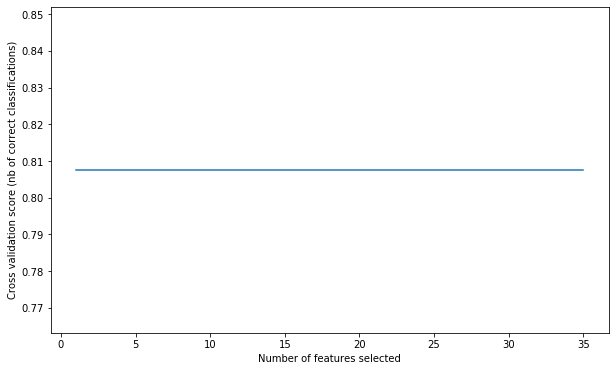

In [236]:

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=4000), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Model accuracy jumps when using 3 features and then hoves in the 90% accuracy range with additional features added. What are the three features that are meaningful here? Try the RFE again but select three. 

In [238]:
## Let'a figure out which features are most important to the model using recursive feature elimination. 



X = df[features]
y = df['Attendance']
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs', max_iter = 3000)
# create the RFE model and select 3 attributes
rfe = RFE(model,9)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


Selected features: ['Age', 'Hypertension', 'AppointmentID', 'WaitFromScheduledDate', 'ScheduledHourOfDay', 'PriorAppts', 'PriorAttendanceRate', '0DaysWait', '831DaysWait']


So this simple logistic regression is drawing from Appointment Frequency, Absence Frequency, and handicap conditions. Some questions to consider:

- How does this model interpret handicap? Even when we look at the top 20 variables that correlate with attendance, the handicap variable is not one of them. We want to investigate this further.
- How reliable is a model that is is dominated by three variables, where two of them have been engineered by the dataset? 
- There's a positive correlation between the appointment frequency and attendance. Does this model bias make wrong assumptions about new patients not attending their appointments? 

### PCA Analysis

"Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set. Richard Bellman described this phenomenon in 1961 as the Curse of Dimensionality where “Many algorithms that work fine in low dimensions become intractable when the input is high-dimensional. "

https://medium.com/apprentice-journal/pca-application-in-machine-learning-4827c07a61db

### Feature Scaling



In [239]:
X_tr=pd.DataFrame(data=X_train,columns=X_train.columns)

In [240]:
scaler = StandardScaler()

X_tr[X_train.columns] = scaler.fit_transform(X_tr[X_train.columns])

X_tr.describe()

,Gender,Age,Scholarship,Hypertension,AppointmentID,Diabetes,Alcoholism,Handicap,SMS_Reminders,Friday,...,ScheduledMonday,ScheduledTuesday,ScheduledWednesday,ScheduledThursday,ScheduledFriday,0DaysWait,12DaysWait,37DaysWait,831DaysWait,32DaysWait
count,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,...,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04,5.357700e+04
mean,-4.356595e-17,-2.261186e-17,2.533058e-17,-1.133908e-16,4.677803e-15,-5.715959e-17,3.315521e-18,3.448142e-17,-2.519796e-17,-8.355114e-18,...,-7.168157e-17,6.259704e-17,8.089872e-18,1.724071e-18,3.554239e-17,-8.341852e-17,-1.140539e-17,4.376488e-17,-5.304834e-18,-9.707846e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-6.588720e-01,-1.639513e+00,-3.227333e-01,-5.972056e-01,-6.202803e+00,-3.261418e-01,-2.056532e-01,-1.504608e-01,-8.302571e-01,-4.521778e-01,...,-5.129057e-01,-5.618227e-01,-5.282264e-01,-4.377285e-01,-4.571394e-01,-7.043469e-01,-3.641570e-01,-4.851258e-01,-6.103297e-01,-3.133399e-01
25%,-6.588720e-01,-8.472564e-01,-3.227333e-01,-5.972056e-01,-4.961194e-01,-3.261418e-01,-2.056532e-01,-1.504608e-01,-8.302571e-01,-4.521778e-01,...,-5.129057e-01,-5.618227e-01,-5.282264e-01,-4.377285e-01,-4.571394e-01,-7.043469e-01,-3.641570e-01,-4.851258e-01,-6.103297e-01,-3.133399e-01
50%,-6.588720e-01,1.589629e-03,-3.227333e-01,-5.972056e-01,-1.271268e-03,-3.261418e-01,-2.056532e-01,-1.504608e-01,-8.302571e-01,-4.521778e-01,...,-5.129057e-01,-5.618227e-01,-5.282264e-01,-4.377285e-01,-4.571394e-01,-7.043469e-01,-3.641570e-01,-4.851258e-01,-6.103297e-01,-3.133399e-01
75%,1.517746e+00,7.372562e-01,-3.227333e-01,1.674465e+00,8.213154e-01,-3.261418e-01,-2.056532e-01,-1.504608e-01,1.204446e+00,-4.521778e-01,...,-5.129057e-01,-5.618227e-01,-5.282264e-01,-4.377285e-01,-4.571394e-01,1.419755e+00,-3.641570e-01,-4.851258e-01,1.638459e+00,-3.133399e-01
max,1.517746e+00,3.000846e+00,3.098534e+00,1.674465e+00,1.553407e+00,3.066151e+00,4.862554e+00,2.281604e+01,1.204446e+00,2.211520e+00,...,1.949676e+00,1.779921e+00,1.893128e+00,2.284521e+00,2.187516e+00,1.419755e+00,2.746068e+00,2.061321e+00,1.638459e+00,3.191422e+00


In [241]:
X_te = scaler.transform(X_test)

In [242]:
X_te = pd.DataFrame(data = X_test,columns= X_train.columns)

### PCA Analysis

In [243]:
pca = PCA(svd_solver='randomized', random_state=42)
#PCA on the train data
pca.fit(X_tr)
pca.components_

colnames = list(X_tr.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})

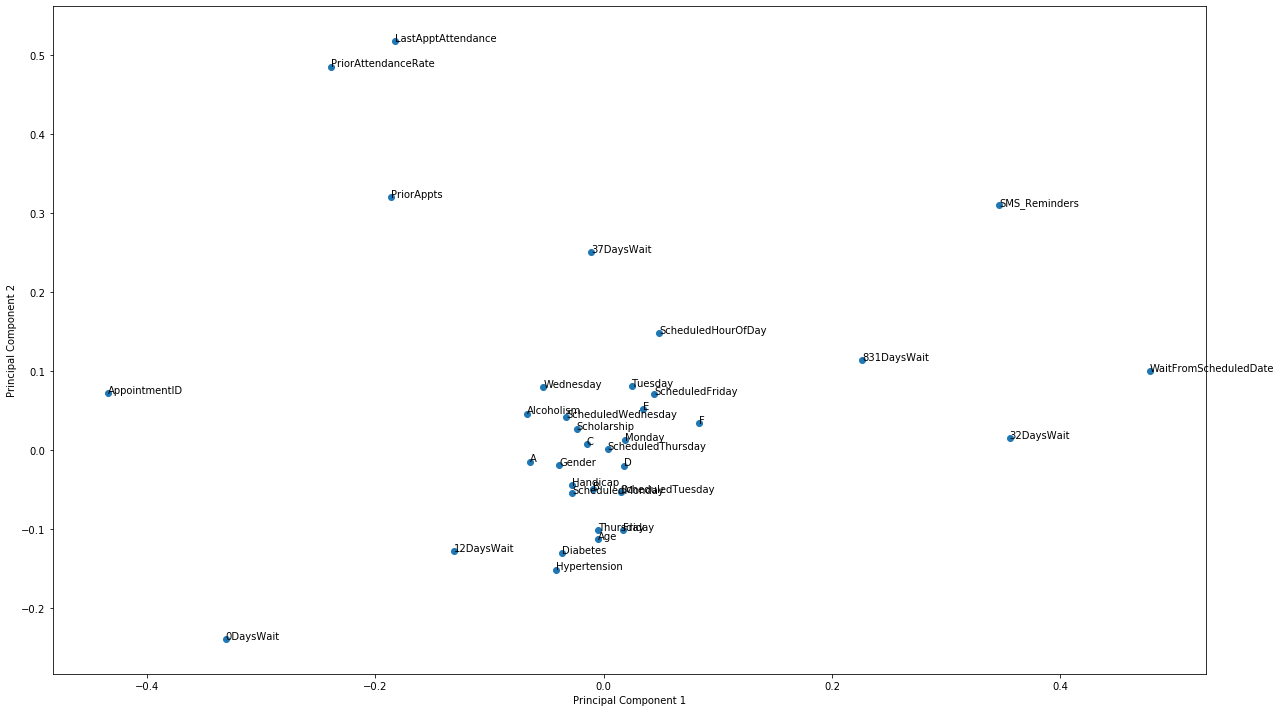

In [244]:
%matplotlib inline
fig = plt.figure(figsize = (18,10))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

Interesting... we can see which variables are clustered near each other and might be experiencing some degreee of a  collinearity issue.

Similiar variables:


[Absencefreq, ApptFreq] <br>
[Age, Diabetes, Hypertension]<br>
[WaitFromScheduledDate, SMSReminders]<br>
A bunch of variables all clustered in the middle of this graph may be causing issues

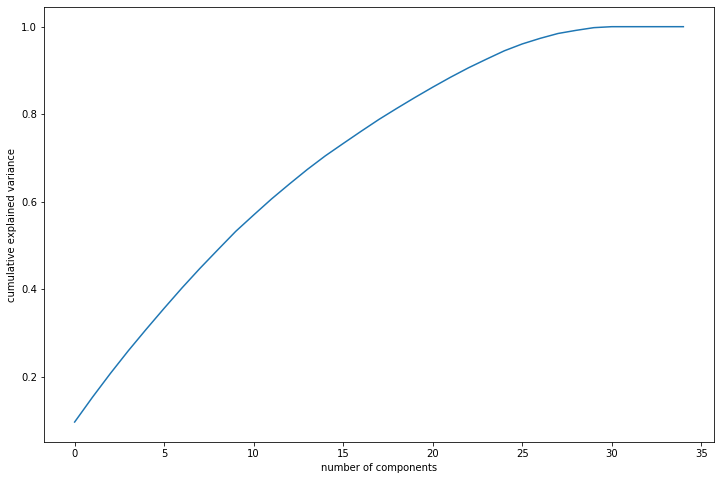

In [245]:
pca.explained_variance_ratio_

#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Select somewhere around 20 features to explain the variance... After that, the the graph of explained variance approaches an asymptote

In [246]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=20)

In [247]:
df_train_pca = pca_final.fit_transform(X_tr)
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

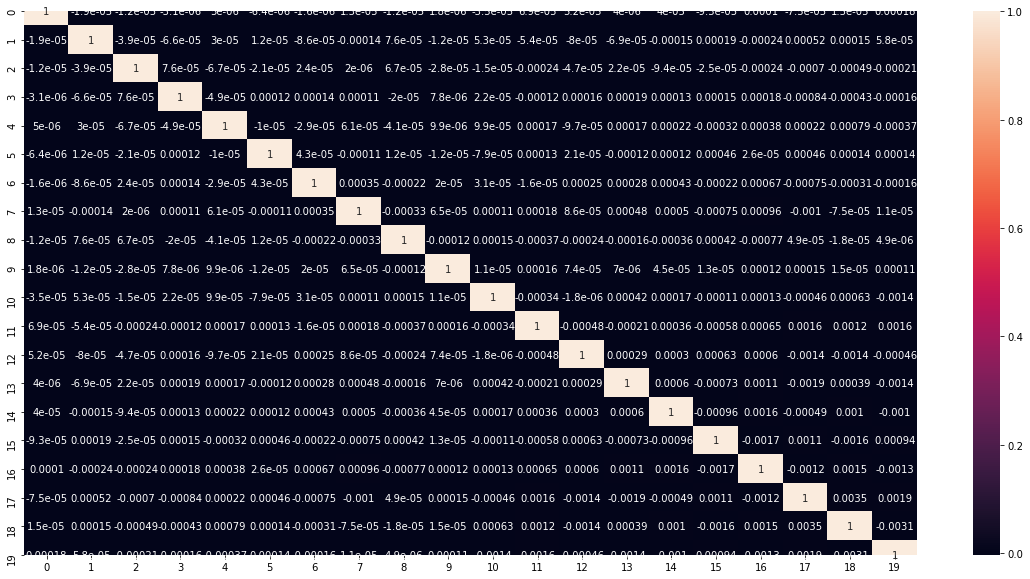

In [248]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

In [249]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.003475651808903808 , min corr:  -0.00308536859245801


Low correlation scores = Confirmed that we've removed multicolinearity issues

In [250]:
#Applying selected components to the test data - 40 components
df_test_pca = pca_final.transform(X_te)

### Logistic Regression Post PCA

In [251]:
#Training the model on the train data
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [252]:
#Making prediction on the train data
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_tr, pred_probs_train))

'0.7'

In [253]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.5'

Predictions on the training data

In [254]:
##Evaluations on the training data
predictions_train = model_pca.predict(df_train_pca)
print(confusion_matrix(y_tr,predictions_train))
print(classification_report(y_tr,predictions_train))

[[   39 10196]
 [   84 43258]]
              precision    recall  f1-score   support

           0       0.32      0.00      0.01     10235
           1       0.81      1.00      0.89     43342

    accuracy                           0.81     53577
   macro avg       0.56      0.50      0.45     53577
weighted avg       0.72      0.81      0.72     53577



In [255]:
#Evaluations on the test data
predictions_test = model_pca.predict(df_test_pca)
print(confusion_matrix(y_test,predictions_test))
print(classification_report(y_test,predictions_test))

[[    0  2649]
 [    0 10746]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2649
           1       0.80      1.00      0.89     10746

    accuracy                           0.80     13395
   macro avg       0.40      0.50      0.45     13395
weighted avg       0.64      0.80      0.71     13395



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The accuracy on our test data drastically fell after performing feature scaling and PCA to nix multicollinearity issues with our data. This severe dip in performance indicates that there aren't many relationships in the data to predict attendance. There may be some multicollinearity issues with our data. So we should be skeptical of any test set accuracy. Sure we might be able to manage a decent test score, but the relationships the model depends upon may be fragile.

In [256]:
# Defining a function to plot the ROC-AUC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

#### Random Forest Model

In [257]:
#Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)
X_tr = X_train
y_tr = y_train



In [258]:
model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Random Forest Accuracy with Default Hyperparameter on the test set',metrics.accuracy_score(y_test, prediction_test))
print('Random Forest AUC with Default Hyperparameter on the test set',metrics.roc_auc_score(y_test, prediction_test))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy with Default Hyperparameter on the test set 0.7767077267637178
Random Forest AUC with Default Hyperparameter on the test set 0.5722355178702734


In [259]:


# GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [260]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.103396,0.011437,0.013086,0.003858,2,{'max_depth': 2},0.720996,0.680913,0.697446,0.710050,...,0.701240,0.013530,4,0.708540,0.697173,0.702473,0.702520,0.703096,0.702761,0.003602
1,0.248936,0.060812,0.018942,0.003628,7,{'max_depth': 7},0.743347,0.723760,0.733275,0.740636,...,0.733324,0.007811,2,0.755568,0.759569,0.755937,0.757348,0.754303,0.756545,0.001797
2,0.328255,0.039647,0.023266,0.004379,12,{'max_depth': 12},0.738871,0.723833,0.732629,0.739950,...,0.733329,0.005815,1,0.855420,0.860204,0.860034,0.862787,0.865640,0.860817,0.003384
3,0.492262,0.065371,0.033152,0.005476,17,{'max_depth': 17},0.718915,0.710536,0.729176,0.729924,...,0.721816,0.007173,3,0.969812,0.972038,0.970145,0.964990,0.969701,0.969337,0.002333


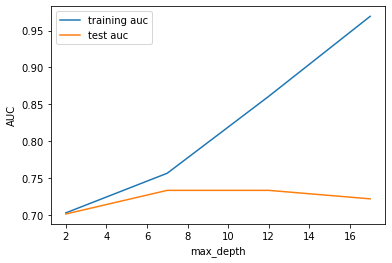

In [261]:


# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.legend()
plt.show()



In [262]:
#GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

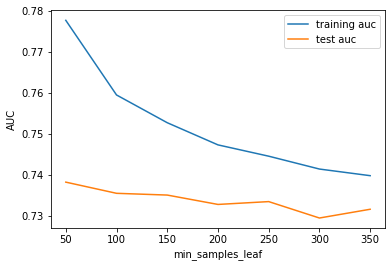

In [263]:
# plotting auc's with min_samples_leaf
scores = rf.cv_results_
pd.DataFrame(scores).head()
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [264]:
# GridSearchCV to find optimal n_estimators



# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(300, 800, 100)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

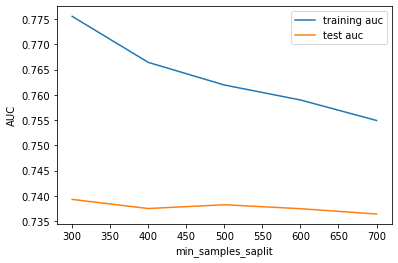

In [265]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_saplit")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [276]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(300, 700, 200),
    'n_estimators': [100,200], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring = 'roc_auc')

In [280]:
grid_search.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [281]:
# printing the optimal accuracy score and hyperparameters
print('We can get an auc of',grid_search.best_score_,'using',grid_search.best_params_)

We can get an auc of 0.7400440618538301 using {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 300, 'n_estimators': 200}


In [282]:
# Fitting the RandomForestClassifier using the best parameters obtained by Grid Search CV on the train set
m1= RandomForestClassifier(n_estimators=100,max_depth=8, min_samples_leaf=100,min_samples_split=300, max_features=10, n_jobs=-1)
m1.fit(X_tr,y_tr)
m1.score(X_test,y_test)

0.8067935796939156

In [283]:
#Predicting probabilities on the balanced training data set, imbalanced training data set and tst set
y_trprob = m1.predict_proba(X_tr)[:,1]
y_trainprob = m1.predict_proba(X_train)[:,1]
y_testprob = m1.predict_proba(X_test)[:,1]

In [284]:
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the balanced training dataset
y_tr_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), y_trprob.tolist())),
              columns=['Attendance','Attendance_prob'])
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the imbalanced training dataset
y_train_pred_final = pd.DataFrame(list(zip(y_train.tolist(), y_trainprob.tolist())),
              columns=['Attendance','Attendance_prob'])


In [285]:
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the testing dataset
y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), y_testprob.tolist())),
              columns=['Attendance','Attendance_prob'])

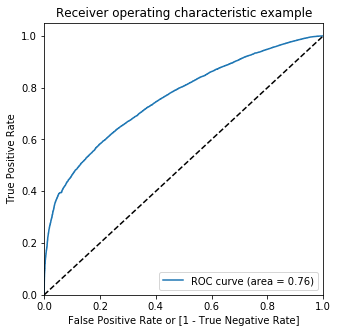

In [286]:
fpr, tpr, thresholds = metrics.roc_curve( y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob, drop_intermediate = False )
#Fitting on the training dataset
draw_roc(y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob)

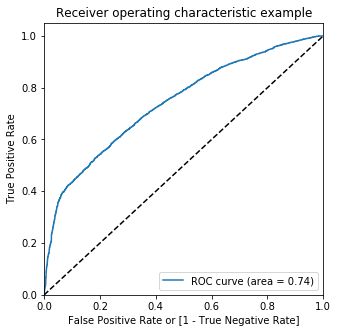

In [287]:
##Fitting on the test set
fpr, tpr, thresholds = metrics.roc_curve(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob, drop_intermediate = False )
draw_roc(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob)

In [288]:
# Let's create columns with different probability cutoffs on the test set
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.Attendance_prob.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

,Attendance,Attendance_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.790823,1,1,1,1,1,1,1,1,0,0
1,0,0.642967,1,1,1,1,1,1,1,0,0,0
2,1,0.832866,1,1,1,1,1,1,1,1,1,0
3,1,0.763088,1,1,1,1,1,1,1,1,0,0
4,1,0.786424,1,1,1,1,1,1,1,1,0,0


In [289]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci'])


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]
print(cutoff_df)



     prob  accuracy     sensi     speci     preci
0.0   0.0  0.805450  1.000000  0.000000  0.805450
0.1   0.1  0.805450  1.000000  0.000000  0.805450
0.2   0.2  0.805450  1.000000  0.000000  0.805450
0.3   0.3  0.805450  1.000000  0.000000  0.805450
0.4   0.4  0.805450  1.000000  0.000000  0.805450
0.5   0.5  0.806794  0.999722  0.008058  0.806671
0.6   0.6  0.809033  0.987024  0.072141  0.814954
0.7   0.7  0.764166  0.848457  0.415196  0.857277
0.8   0.8  0.563270  0.496246  0.840752  0.928064
0.9   0.9  0.501232  0.397905  0.929010  0.958687


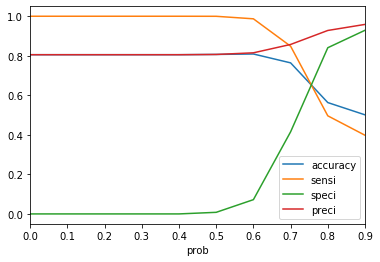

In [290]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci', 'preci'])
plt.show()

In [300]:

print(metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.5]))
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.5]))

[[   21  2585]
 [    3 10786]]
              precision    recall  f1-score   support

           0       0.88      0.01      0.02      2606
           1       0.81      1.00      0.89     10789

    accuracy                           0.81     13395
   macro avg       0.84      0.50      0.45     13395
weighted avg       0.82      0.81      0.72     13395



Similar overall accuracy to other models. We observe 88% precision for no-shows- meaning that when the algorithm does make a prediction that a prediction will not attend their appointment, we have a strong confidence in that prediction. Unfortunately, this model isn't picking up on many cases of no-shows. The algorithm only identified 24 cases which were predicted as no shows. Meanwhile there are 2585 patients who actually missed their appointment but the algorithm predicts their attendance. 

In [302]:
feature_importances = pd.DataFrame(m1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)



,importance
WaitFromScheduledDate,0.311832
0DaysWait,0.242390
Age,0.093060
AppointmentID,0.085270
831DaysWait,0.057741
SMS_Reminders,0.050340
PriorAttendanceRate,0.032692
PriorAppts,0.031685
ScheduledHourOfDay,0.019886
37DaysWait,0.010622


Not surprising the model draws upon wait time and whether the patient scheduled an appointment for that day. The fourth most important feature in this model is the appointment ID. We should expect this will break pretty quickly in other contexts. This is a fairly obvious example of using a feature in model building that's better to leave out. Because of the lack of medical expertise in software development, it's likely that there are other cases where it's better to limit our feature set to clinically sensible variables - but some of those cases are trickier to spot.

### Gradient Boosting Model

In [348]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse



In [356]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)

In [357]:
# Load data
X_trainGB = X_train.to_numpy()
X_testGB = X_test.to_numpy()

In [358]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_trainGB, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.1379


Text(0, 0.5, 'Deviance')

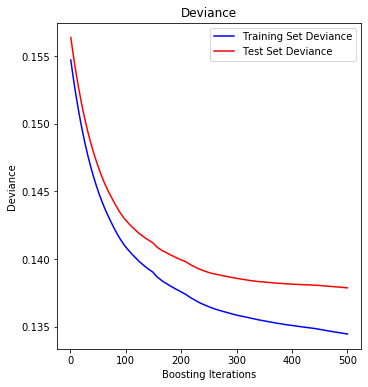

In [359]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_testGB)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

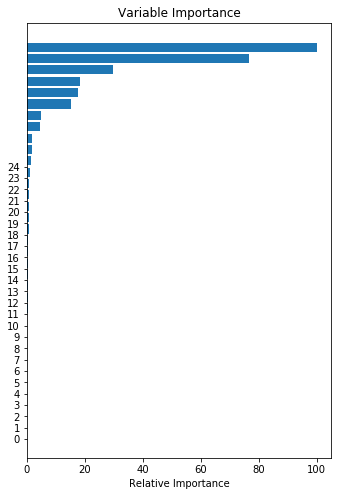

In [360]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12,8))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(0, 25, step=1))


#plt.yticks(pos, df.get_feature_names([sorted_idx]))
#need to look for a different package: get_feature_names no longer works
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()


In [361]:
importances = feature_importance
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]
names[:9]

['WaitFromScheduledDate',
 '0DaysWait',
 'Age',
 'PriorAppts',
 'PriorAttendanceRate',
 'AppointmentID',
 'ScheduledHourOfDay',
 'SMS_Reminders',
 'LastApptAttendance']

Feature ranking:
1. feature 14 (100.000000)
WaitFromScheduledDate
2. feature 30 (76.493865)
0DaysWait
3. feature 1 (29.619543)
Age
4. feature 16 (18.224422)
PriorAppts
5. feature 17 (17.574359)
PriorAttendanceRate
6. feature 4 (15.183639)
AppointmentID
7. feature 15 (4.711160)
ScheduledHourOfDay
8. feature 8 (4.656080)
SMS_Reminders
9. feature 18 (1.593839)
LastApptAttendance
10. feature 6 (1.587773)
Alcoholism
11. feature 22 (1.295746)
D
12. feature 2 (1.167867)
Scholarship
13. feature 19 (0.843921)
A
14. feature 20 (0.657747)
B
15. feature 28 (0.605804)
ScheduledThursday
16. feature 0 (0.588713)
Gender
17. feature 23 (0.554693)
E
18. feature 31 (0.523578)
12DaysWait
19. feature 3 (0.389098)
Hypertension
20. feature 27 (0.333685)
ScheduledWednesday
21. feature 5 (0.325744)
Diabetes
22. feature 7 (0.306915)
Handicap
23. feature 10 (0.219370)
Monday
24. feature 33 (0.206655)
831DaysWait
25. feature 24 (0.172379)
F
26. feature 12 (0.151449)
Tuesday
27. feature 11 (0.141297)
Thursday
28. 

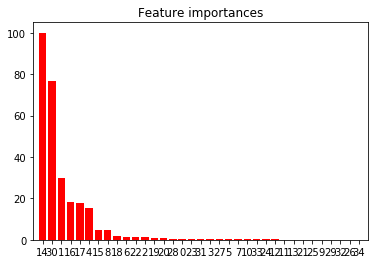

In [362]:
# Build a forest and compute the feature importances
#forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

#forest.fit(X, y)


# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(names[f])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.bar(range(X.shape[1]), importances[indices], color="r",  align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [369]:
selection=[]
for i in y_pred:
    if i >= 0.6:
        selection.append(1)
    else:
        selection.append(0)

selectionfortesting = np.asarray(selection)

In [370]:
print(confusion_matrix(y_test, selectionfortesting))
print(classification_report(y_test, selectionfortesting ))

[[  286  2320]
 [  250 10539]]
              precision    recall  f1-score   support

           0       0.53      0.11      0.18      2606
           1       0.82      0.98      0.89     10789

    accuracy                           0.81     13395
   macro avg       0.68      0.54      0.54     13395
weighted avg       0.76      0.81      0.75     13395



We'll come back to this. What patients is this missing?

In [378]:
y_testprobscore = y_test.copy()

In [385]:
y_testprobscore

13785     1
32823     0
33584     1
50153     1
103279    1
         ..
103765    1
89614     1
90687     1
62781     1
103785    1
Name: Attendance, Length: 13395, dtype: int8

In [387]:
y_testprob = pd.DataFrame(pd.np.column_stack([
    y_testprobscore, y_pred]), index = y_testprobscore.index, columns =['Attendance','Prob'])

In [399]:
example = df[df.index== 88011]
exampleX = example[features]
exampleY = example['Attendance']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(exampleX)

       Gender  Age  Scholarship  Hypertension  AppointmentID  Diabetes  \
88011       1   48            1             0        5701217         0   

       Alcoholism  Handicap  SMS_Reminders  Friday  Monday  Thursday  Tuesday  \
88011           0         0              0       0       0         0        0   

       Wednesday  WaitFromScheduledDate  ScheduledHourOfDay  PriorAppts  \
88011          1                     16                  10           1   

       PriorAttendanceRate  LastApptAttendance  A  B  C  D  E  F  \
88011                  0.0                 0.0  0  0  1  0  0  0   

       ScheduledMonday  ScheduledTuesday  ScheduledWednesday  \
88011                1                 0                   0   

       ScheduledThursday  ScheduledFriday  0DaysWait  12DaysWait  37DaysWait  \
88011                  0                0          0           0           0   

       831DaysWait  32DaysWait  
88011            1           0  


In [414]:
exampleY

88011    1
Name: Attendance, dtype: int8

In [471]:
slightchange = exampleX.copy()
slightchange.loc[88011,'ScheduledHourOfDay']=18


In [472]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(slightchange)

       Gender  Age  Scholarship  Hypertension  AppointmentID  Diabetes  \
88011       1   48            1             0        5701217         0   

       Alcoholism  Handicap  SMS_Reminders  Friday  Monday  Thursday  Tuesday  \
88011           0         0              0       0       0         0        0   

       Wednesday  WaitFromScheduledDate  ScheduledHourOfDay  PriorAppts  \
88011          1                     16                  18           1   

       PriorAttendanceRate  LastApptAttendance  A  B  C  D  E  F  \
88011                  0.0                 0.0  0  0  1  0  0  0   

       ScheduledMonday  ScheduledTuesday  ScheduledWednesday  \
88011                1                 0                   0   

       ScheduledThursday  ScheduledFriday  0DaysWait  12DaysWait  37DaysWait  \
88011                  0                0          0           0           0   

       831DaysWait  32DaysWait  
88011            1           0  


In [473]:
clf.predict(exampleX)

array([0.50264448])

In [474]:
clf.predict(slightchange)

array([0.50189652])

In [328]:
from keras import Sequential
from keras.layers import Dense

In [329]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighborhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Attendance',
       'AppointmentDayOfWeek', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday', 'ScheduledDayOfWeek', 'ScheduledMonday',
       'ScheduledTuesday', 'ScheduledWednesday', 'ScheduledThursday',
       'ScheduledFriday', 'WaitFromScheduledDate', 'ScheduledHourOfDay',
       'PriorAppts', 'PriorAttendanceRate', 'LastApptDate',
       'LastApptAttendance', 'NeighborhoodGrouping', 'A', 'B', 'C', 'D', 'E',
       'F', 'DaysBeforeCat', '0DaysWait', '12DaysWait', '37DaysWait',
       '831DaysWait', '32DaysWait'],
      dtype='object')

In [214]:
import time
from datetime import datetime


1570032682

In [331]:
# creating input features and target variables
cols =['Gender', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 
       'Thursday', 'Tuesday',
       'Wednesday', 'WaitFromScheduledDate',
       'ScheduledHourOfDay', 'PriorAppts', 'PriorAttendanceRate', 'LastApptAttendance',
        'A', 'B', 'C', 'D', 'E', 'F',
       'ScheduledMonday', 'ScheduledTuesday', 'ScheduledWednesday',
       'ScheduledThursday', 'ScheduledFriday', '0DaysWait', '12DaysWait',
       '37DaysWait', '831DaysWait', '32DaysWait']
X = df[cols]
y = df['Attendance']

In [332]:
#standardizing the input feature
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [333]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [337]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(50, activation='relu', kernel_initializer='random_normal', input_dim=34))#Second  Hidden Layer
classifier.add(Dense(50, activation='relu', kernel_initializer='random_normal'))#Output Layer


classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [338]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
#classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [339]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=10, epochs=100)


Epoch 1/100
53577/53577 [==============================] - 6s 116us/step - loss: 0.4378 - accuracy: 0.8070
Epoch 2/100
53577/53577 [==============================] - 5s 100us/step - loss: 0.4309 - accuracy: 0.8075
Epoch 3/100
53577/53577 [==============================] - 5s 97us/step - loss: 0.4284 - accuracy: 0.8092
Epoch 4/100
53577/53577 [==============================] - 5s 98us/step - loss: 0.4263 - accuracy: 0.8110
Epoch 5/100
53577/53577 [==============================] - 5s 98us/step - loss: 0.4248 - accuracy: 0.8126
Epoch 6/100
53577/53577 [==============================] - 5s 99us/step - loss: 0.4238 - accuracy: 0.8122
Epoch 7/100
53577/53577 [==============================] - 5s 101us/step - loss: 0.4218 - accuracy: 0.8136
Epoch 8/100
53577/53577 [==============================] - 5s 101us/step - loss: 0.4207 - accuracy: 0.8144
Epoch 9/100
53577/53577 [==============================] - 5s 102us/step - loss: 0.4188 - accuracy: 0.8153
Epoch 10/100
53577/53577 [==============

53577/53577 [==============================] - 5s 95us/step - loss: 0.3716 - accuracy: 0.8405
Epoch 76/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3720 - accuracy: 0.8390
Epoch 77/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3712 - accuracy: 0.8396
Epoch 78/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3709 - accuracy: 0.8408
Epoch 79/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3709 - accuracy: 0.8400
Epoch 80/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3706 - accuracy: 0.8404
Epoch 81/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3699 - accuracy: 0.8408
Epoch 82/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3703 - accuracy: 0.8410
Epoch 83/100
53577/53577 [==============================] - 5s 91us/step - loss: 0.3697 - accuracy: 0.8405
Epoch 84/100
53577/53577 [========================

In [340]:
eval_model=classifier.evaluate(X_train, y_train)
eval_model
#[Loss, Accuracy]

53577/53577 [==============================] - 1s 15us/step


[0.3558175892044144, 0.8484610915184021]

In [341]:
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred ))

[[  377  2180]
 [  533 10305]]
              precision    recall  f1-score   support

           0       0.41      0.15      0.22      2557
           1       0.83      0.95      0.88     10838

    accuracy                           0.80     13395
   macro avg       0.62      0.55      0.55     13395
weighted avg       0.75      0.80      0.76     13395



## Findings and Suggestions for the Practice

- No shows are more apparent in individuals 20-40 years old. Older patients are much more likely to attend their scheduled appointments. Communicate the value of attending their appointments for preventative care to these younger populations. 
- Texts do not seem to make a signficant influence on patient attendance when the appointment is scheduled for a few days in the future. May be more meaningful to focus on texting all individuals who have appointments far into the future. 
- Patients are more often missing friday and saturday appointments than any other days of the week. Look into why this is the case. IS it possible to schedule more appointments on Wednesday or Thursday when the facility sees the highest rate of attendance?
- Can accurately predict 91% of the instances in the test set with logistic regression, random forest, and gradient boosting {Attend appointment or No-show}. May improve model accuracy to use an ensemble of models. Run more tests on more robust data.
- These models are primarily driven from the features, appointment frequency and absence frequency. After performing PCA on the data and running logistic regression, these models could be instances of overfitting on these two similar variables. Recommend further study on these models before any clinical utility. 
- The northern regions are attending their appointments more frequently than the southern region. Regions A, B, and C (South) report higher frequency of patients with alcoholism, diabetes, and those on scholarship than regions D, E, and F (North). Focus clinical efforts on drawing more patients from these region for preventative measures and earier interventions. 


## Discussion Questions

- What are some potential sources of bias in this algorithm? What might these biases mean for practice if this sort of algorithm were to roll out?
    - Ex: Roughly 9% of patients in the data are on scholarship. According to wikipedia, the scholarship rate across the state was 26% in 2017. So this may be a wealthier population we're examining in the data compared to the state. According to an article published in the Atlantic, wealthier people often see private doctors instead of public healthcare - unless their private doctors prescribe costly procedures, which are often covered in Brazil's universal healthcare.
    - How does the first logistic regression model interpret handicap? Even when we look at the top 20 variables that correlate with attendance, the handicap variable is not one of them. Yet the model seems to draw from this feature as one of the primary three that contribute to 91% accuracy.
    - All of the models we built placed heavy important on appointment frequency and absence frequency. Will this negatively impact new patients?
- What is the best manner to apply the results of this sort of algorithm, if at all?
    - What should the algorithm return? 
- What are the important variables that an algorithm should have access to? Where should access be limited?
    - Are there any accessible variables that pose risk of building a model to predict those patient information (ex: handicap, alcoholism, diabetes)? What data should the algorithm tap in the facility?
- What are some common evaluation metrics to understand how well a classifier performs?
    - What are some best practices for disclosing how models were trained and tested?
- Would this be an AI task that would be important to monitor in a registry? If so, what data would you want to collect about this task?
- What do we observe about the patients who are consistently predicted incorrectly by the algorithm?
- How could I get started on some inhouse ML projects?